# **Movie Recommendation System**

---

## **1. Data Collection**

In [1]:
# Importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Setting up some parameters for the workbook

pd.set_option('display.max_rows', 50)
pd.options.display.max_columns = None


%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (25,5)

In [3]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\bibek debnath\anaconda3\anaconda\lib\site-packages\scikit_surprise-1.1.3-py3.11-win-amd64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [4]:
!pip install fuzzywuzzy

DEPRECATION: Loading egg at c:\users\bibek debnath\anaconda3\anaconda\lib\site-packages\scikit_surprise-1.1.3-py3.11-win-amd64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [5]:
pip install scikit-surprise


Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\bibek debnath\anaconda3\anaconda\lib\site-packages\scikit_surprise-1.1.3-py3.11-win-amd64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [6]:
from scipy import sparse


from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

import xgboost as xgb

from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SlopeOne
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV

In [7]:
from datetime import datetime
import os
import random
import gc

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

## **2. Data Preprocessing**



In [8]:
# Loading the dataset

movie_ratings = pd.read_csv("ratings.csv")
movies = pd.read_csv("movies.csv")

In [9]:
import pandas as pd

# Load the dataset
data = pd.read_csv("movies.csv")

# Get the number of rows and columns
num_rows, num_columns = data.shape

print("Number of rows:", num_rows)
print("Number of columns:", num_columns)


Number of rows: 9742
Number of columns: 3


In [10]:
import pandas as pd

# Load the dataset
data = pd.read_csv("ratings.csv")

# Get the number of rows and columns
num_rows, num_columns = data.shape

print("Number of rows:", num_rows)
print("Number of columns:", num_columns)


Number of rows: 100836
Number of columns: 4


In [11]:
movies.head()

,movieId,title,genres
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji,Adventure|Children|Fantasy
2,3,Grumpier Old Men,Comedy|Romance
3,4,Waiting to Exhale,Comedy|Drama|Romance
4,5,Father of the Bride Part II,Comedy


In [12]:
# Creating a newId for every movie to reduce the range of existing movieId

movies["newId"] = range(1, movies["movieId"].nunique()+1)

In [13]:
# Converting the the UTC timestamp to Datetime
import numpy as np

movie_ratings["timestamp"] = movie_ratings["timestamp"].apply(lambda x: datetime.utcfromtimestamp(x).strftime("%Y-%m-%d") if not np.isnan(x) else np.nan)



# Merging the movies and ratings data files
movie_ratings = movie_ratings.merge(movies, how="left", on="movieId")

# Renaming the timestamp to date
movie_ratings.rename(columns={"timestamp": "date"}, inplace=True)

# Updating the movieId with the newId
movie_ratings["movieId"] = movie_ratings["newId"]
movies["movieId"] = movies["newId"]

In [14]:
# Dropping the newId from the datasets
movie_ratings.drop(["newId"], axis=1, inplace=True)
movies.drop(["newId"], axis=1, inplace=True)

# Sorting ratings based on date
movie_ratings.sort_values(by = "date", inplace = True)
movie_ratings.reset_index(drop=True, inplace=True)

In [15]:
# Checking the features and no. of records in the dataset

print("The number of records are : ", movie_ratings.shape[0])
print("The number of features are : ", movie_ratings.shape[1])
print("The list of features is : ", movie_ratings.columns)
movie_ratings.head()

The number of records are :  100836
The number of features are :  6
The list of features is :  Index(['userId', 'movieId', 'rating', 'date', 'title', 'genres'], dtype='object')


,userId,movieId,rating,date,title,genres
0,429,507,5.0,1996-03-29,Aladdin,Adventure|Animation|Children|Comedy|Musical
1,429,204,4.0,1996-03-29,Forget Paris,Comedy|Romance
2,429,203,4.0,1996-03-29,French Kiss,Action|Comedy|Romance
3,429,201,2.0,1996-03-29,Exit to Eden,Comedy
4,429,194,3.0,1996-03-29,Drop Zone,Action|Thriller


In [16]:
#Observations:

#1. There are 6 features: userId, movieId, rating, date, title and genres.

### Data Cleaning




In [17]:
# Checking for duplicates

print("No. of duplicates records in the dataset : ", movie_ratings.columns.duplicated().sum())

No. of duplicates records in the dataset :  0


In [18]:
#Observations:
# There are no duplicate records in the dataset.

In [19]:
# Checking the columns' titles and datatypes

movie_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
 3   date     100836 non-null  object 
 4   title    100836 non-null  object 
 5   genres   100836 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 4.6+ MB


# Handling Missing Values



In [20]:
# Checking the number of missing values in data

movie_ratings.isna().sum()

userId     0
movieId    0
rating     0
date       0
title      0
genres     0
dtype: int64

In [21]:
#Observations:

# It looks like that the dataset is well maintained as we do not see any missing values, which is good.

# Exploratory Data Analysis



## Univariate Analysis



In [22]:
# Checking the feature "userID"

total_users = len(np.unique(movie_ratings["userId"]))
print("The count of unique userID in the dataset is : ", total_users)
print("The top 5 userID in the dataset are : \n", movie_ratings["userId"].value_counts()[:5])

The count of unique userID in the dataset is :  610
The top 5 userID in the dataset are : 
 userId
414    2698
599    2478
474    2108
448    1864
274    1346
Name: count, dtype: int64


In [23]:
#Observations:

#1. "userId" are the Users that were selected at random for inclusion and their ids have been anonymized.
#2. There are 138K+ unique users in the dataset.
#3. userId 118205 has around 9K records in the dataset.

In [24]:
# Checking the feature "movieID"

total_movies = len(np.unique(movie_ratings["movieId"]))
print("The count of unique movieID in the dataset is : ", total_movies)
print("The top 5 movieID in the dataset are : \n", movie_ratings["movieId"].value_counts()[:5])

The count of unique movieID in the dataset is :  9724
The top 5 movieID in the dataset are : 
 movieId
315     329
278     317
258     307
511     279
1940    278
Name: count, dtype: int64


In [25]:
#Observations:

#1. "movieId" represents the movies with at least one rating or tag in the dataset.
#2. There are close to 26K+ unique movies in the dataset.
#3. movieId 294, 353, 316 and 588 are few popular movies which has been rated over 60K times.

In [26]:
# Helper function to keep numeric labels unchanged
def changingLabels(number):
    return number


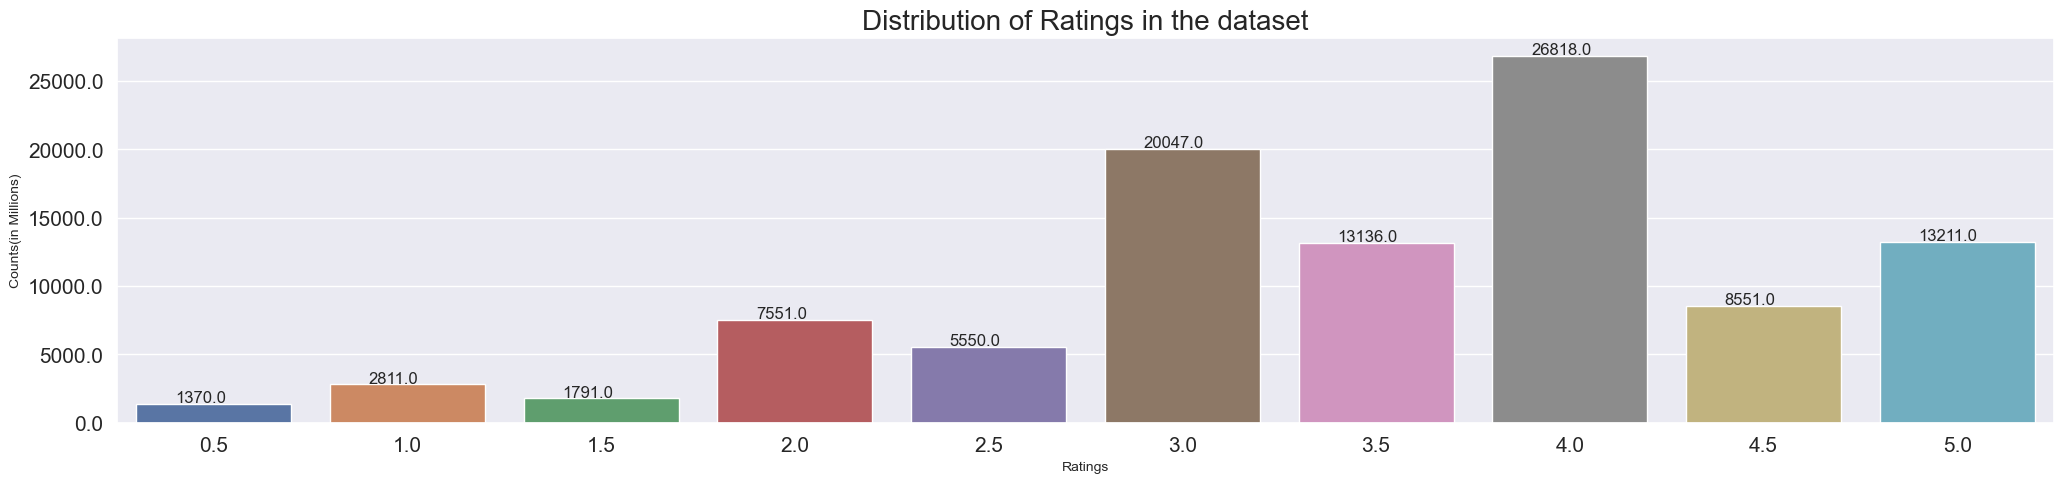

In [27]:
# Checking the feature "rating"

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.countplot(x="rating", data=movie_ratings, ax=axes)  # Ensure 'x=' is used instead of just passing the column name as a string
axes.set_yticklabels([changingLabels(num) for num in axes.get_yticks()])
for p in axes.patches:
    axes.annotate('{}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+100))

plt.tick_params(labelsize=15)
plt.title("Distribution of Ratings in the dataset", fontsize=20)
plt.xlabel("Ratings", fontsize=10)
plt.ylabel("Counts(in Millions)", fontsize=10)
plt.show()


In [28]:
#Observations:

#1. The ratings given by users to movies lies in between 0.5 to 5.
#2. A high proportion of the movies have been rated 3, 3.5 or 4 by the users.
#3. The distribution of ratings look a bit left skewed as large proportion of ratings is in between 3 to 5.

In [29]:
# Convert the "date" column to datetime type
movie_ratings["date"] = pd.to_datetime(movie_ratings["date"], errors='coerce')

# Check if there are any missing values in the "date" column
missing_dates = movie_ratings["date"].isnull().sum()
if missing_dates > 0:
    print("There are", missing_dates, "missing values in the 'date' column.")

# Now you can proceed with your operations on the "date" column
print("The count of unique dates in the dataset is:", movie_ratings["date"].nunique())
print("The first rating was given on:", movie_ratings["date"].min())
print("The latest rating was given on:", movie_ratings["date"].max())
print("The top 5 dates in the dataset are:\n", movie_ratings["date"].value_counts().head())


The count of unique dates in the dataset is: 4110
The first rating was given on: 1996-03-29 00:00:00
The latest rating was given on: 2018-09-24 00:00:00
The top 5 dates in the dataset are:
 date
2017-06-26    1014
2007-05-14     878
2017-05-03     866
2000-08-08     709
2015-06-28     606
Name: count, dtype: int64


In [30]:
#Observations:

#1. There are 4K unique dates when the ratings were given by a user to a movie.
#2. The first rating was given on 1995-01-09 and the latest rating was given on 2015-03-31.
#3. Around 1K+ ratings were observed on 2000-11-20.

In [31]:
# Checking the feature "title"
movie_list = movie_ratings["title"].unique()
print("The count of unique title in the dataset is : ", movie_ratings["title"].nunique())
print("The top 5 title in the dataset are : \n", movie_ratings["title"].value_counts()[:5])

The count of unique title in the dataset is :  9467
The top 5 title in the dataset are : 
 title
Forrest Gump                  329
Shawshank Redemption, The     317
Pulp Fiction                  307
Silence of the Lambs, The     279
Matrix, The                   278
Name: count, dtype: int64


In [32]:
#Observations:

#1. There are 9K+ unique movie titles in the dataset.
#2. Pulp Fiction, Forrest Gump, Shawshank Redemption and Silence of the Lambs are the top 4 movies in terms of no. of ratings received which are over 60K+ for each one.

In [33]:
unique_genres = {}

def ExtractGenres(x):
    if pd.isna(x):
        return
    for g in x.split("|"):
        if g not in unique_genres:
            unique_genres[g] = 1
        else:
            unique_genres[g] += 1

movie_ratings["genres"].apply(ExtractGenres)
print("Genres extracted from the dataset.")

# Display the unique genres along with their count
for genre, count in unique_genres.items():
    print(genre, ":", count)


Genres extracted from the dataset.
Adventure : 24161
Animation : 6988
Children : 9208
Comedy : 39053
Musical : 4138
Romance : 18124
Action : 30635
Thriller : 26452
Drama : 41928
Sci-Fi : 17243
Crime : 16681
Film-Noir : 870
Mystery : 7674
War : 4859
IMAX : 4145
Horror : 7291
Western : 1930
Fantasy : 11834
Documentary : 1219
(no genres listed) : 47


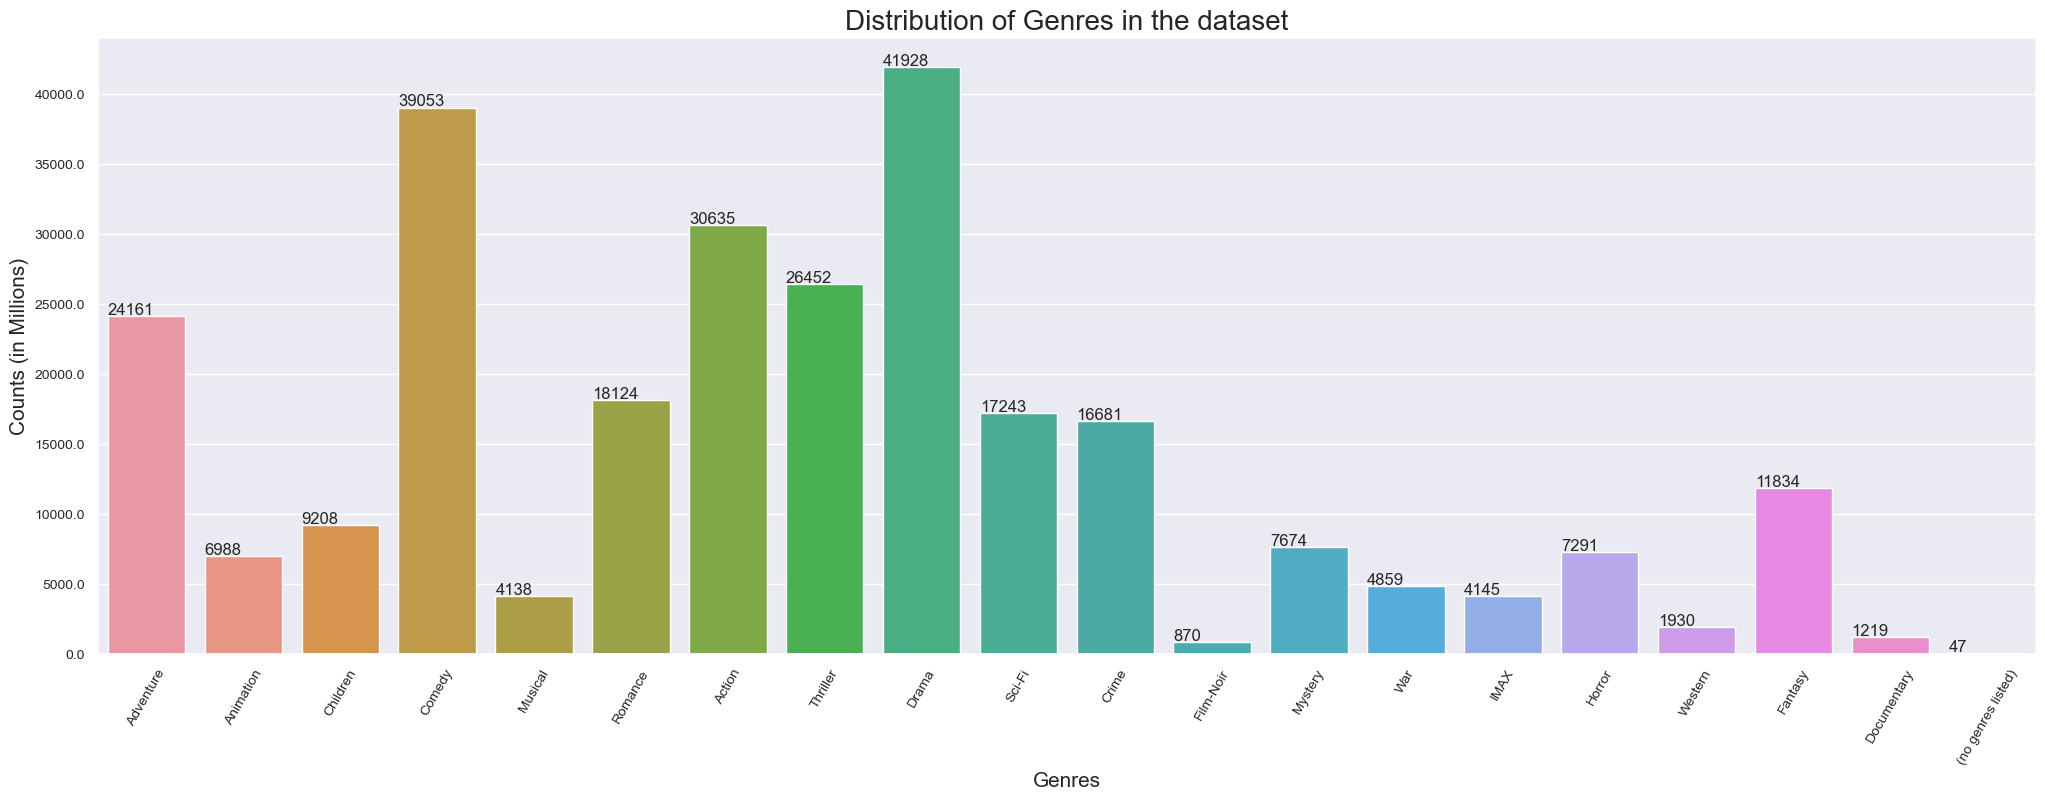

In [34]:
# Visualizing the feature "Genres"
genres_df = pd.DataFrame(list(unique_genres.items()))
genres_df.columns = ["Genre", "Count"] 

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 8), sharey=True)

sns.barplot(y="Count", x="Genre", data=genres_df, ax=axes)
axes.set_yticklabels([changingLabels(num) for num in axes.get_yticks()])
for p in axes.patches:
    axes.annotate('{}'.format(int(p.get_height())), (p.get_x(), p.get_height()+100))

plt.tick_params(labelsize = 15)
plt.title("Distribution of Genres in the dataset", fontsize = 20)
plt.xlabel("Genres", fontsize = 15)
plt.xticks(rotation=60, fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel("Counts (in Millions)", fontsize = 15)
plt.show()

In [35]:
#Observations:

#1. There are 19 different genres of movies while there are few whose genre has not been mentioned.
#2. Drama, Comedy, Action and Thriller are top 4 genres of movies present in the dataset.

In [36]:
movie_ratings.head()

,userId,movieId,rating,date,title,genres
0,429,507,5.0,1996-03-29,Aladdin,Adventure|Animation|Children|Comedy|Musical
1,429,204,4.0,1996-03-29,Forget Paris,Comedy|Romance
2,429,203,4.0,1996-03-29,French Kiss,Action|Comedy|Romance
3,429,201,2.0,1996-03-29,Exit to Eden,Comedy
4,429,194,3.0,1996-03-29,Drop Zone,Action|Thriller


#### Train & test Splitting


In [37]:
# Creating the train test set
if not os.path.isfile("TrainData.pkl"):
    print("Creating Train Data and saving it..")
    movie_ratings.iloc[:int(movie_ratings.shape[0] * 0.80)].to_pickle("TrainData.pkl")
    Train_Data = pd.read_pickle("TrainData.pkl")
    Train_Data.reset_index(drop=True, inplace=True)
else:
    print("Loading Train Data..")
    Train_Data = pd.read_pickle("TrainData.pkl")
    Train_Data.reset_index(drop=True, inplace=True)

if not os.path.isfile("TestData.pkl"):
    print("Creating Test Data and saving it..")
    movie_ratings.iloc[int(movie_ratings.shape[0] * 0.80):].to_pickle("TestData.pkl")
    Test_Data = pd.read_pickle("TestData.pkl")
    Test_Data.reset_index(drop=True, inplace=True)
else:
    print("Loading Test Data..")
    Test_Data = pd.read_pickle("TestData.pkl")
    Test_Data.reset_index(drop=True, inplace=True)

Loading Train Data..
Loading Test Data..


In [38]:
Train_Data.head()

,userId,movieId,rating,date,title,genres
0,429,507,5.0,1996-03-29,Aladdin,Adventure|Animation|Children|Comedy|Musical
1,429,204,4.0,1996-03-29,Forget Paris,Comedy|Romance
2,429,203,4.0,1996-03-29,French Kiss,Action|Comedy|Romance
3,429,201,2.0,1996-03-29,Exit to Eden,Comedy
4,429,194,3.0,1996-03-29,Drop Zone,Action|Thriller


In [39]:
# Creating list of unique movies from Train Set
movie_list_in_training = Train_Data.drop_duplicates(subset=["title"], keep="first")[["movieId", "title", "genres"]]
movie_list_in_training = movie_list_in_training.reset_index(drop=True)
movie_list_in_training.head()

,movieId,title,genres
0,507,Aladdin,Adventure|Animation|Children|Comedy|Musical
1,204,Forget Paris,Comedy|Romance
2,203,French Kiss,Action|Comedy|Romance
3,201,Exit to Eden,Comedy
4,194,Drop Zone,Action|Thriller


In [40]:
# Checking the basic statistics for the training data
print("Total Train Data..")
print("Total number of movie ratings in train data : ", str(Train_Data.shape[0]))
print("Number of unique users in train data : ", str(len(np.unique(Train_Data["userId"]))))
print("Number of unique movies in train data : ", str(len(np.unique(Train_Data["movieId"]))))

Total Train Data..
Total number of movie ratings in train data :  80668
Number of unique users in train data :  522
Number of unique movies in train data :  7866


# Bi-variate Analysis

  

#####1. Analyzing the Distribution of Ratings

In [41]:
# Checking basic statistics for "rating"
print("The basic statistics for the feature is : \n", Train_Data["rating"].describe())

The basic statistics for the feature is : 
 count    80668.000000
mean         3.508380
std          1.033348
min          0.500000
25%          3.000000
50%          3.500000
75%          4.000000
max          5.000000
Name: rating, dtype: float64


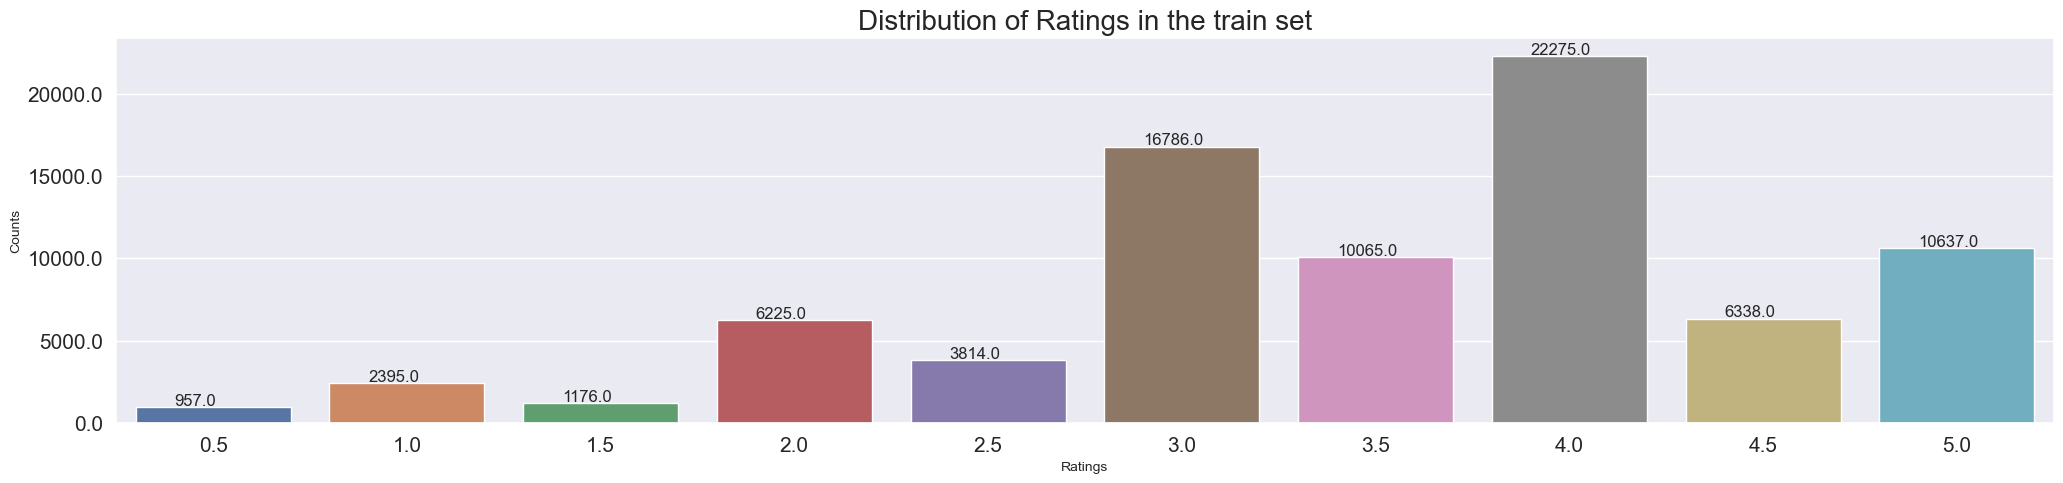

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.countplot(x="rating", data=Train_Data, ax=axes)  # Specify 'x=' for the column name
axes.set_yticklabels([changingLabels(num) for num in axes.get_yticks()])
for p in axes.patches:
    axes.annotate('{}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+100))

plt.tick_params(labelsize=15)
plt.title("Distribution of Ratings in the train set", fontsize=20)
plt.xlabel("Ratings", fontsize=10)
plt.ylabel("Counts", fontsize=10)
plt.show()


In [43]:
#Observations:

#1. The distribution of ratings seems to be similar as before.
#2. The mean and median value are very close to around 3.5.

---

#####**2. Analyzing the number of ratings with date.**

In [44]:
# Extracting the day of week from the date when rating was provided
Train_Data["date"] = pd.to_datetime(Train_Data["date"], errors='coerce')
Train_Data["DayOfWeek"] = Train_Data["date"].dt.strftime('%A')
Train_Data["Weekday"] = Train_Data["date"].apply(lambda x : 1 if x.dayofweek > 5 else 0)

In [45]:
# Converting the number into 'Ks.
def ChangingLabelsInK(number):
    return str(int(number/10**3)) + "K"

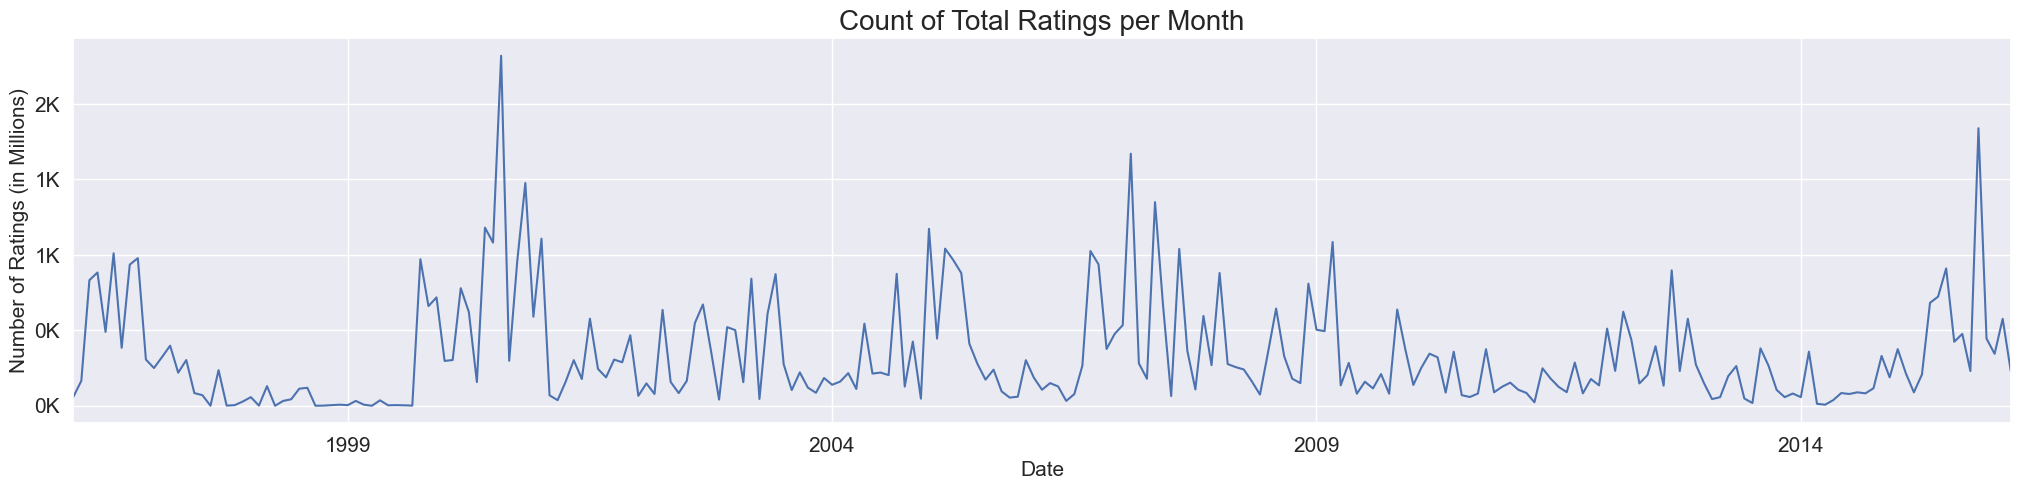

In [46]:
# Visualizing the count of total ratings made per month
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)
axes = Train_Data.resample("m", on = "date")["rating"].count().plot()

axes.set_yticklabels([ChangingLabelsInK(num) for num in axes.get_yticks()])
axes.set_title("Count of Total Ratings per Month", fontsize = 20)
axes.set_xlabel("Date", fontsize = 15)
axes.set_ylabel("Number of Ratings (in Millions)", fontsize = 15)
plt.tick_params(labelsize = 15)
plt.show()

In [47]:
#Observations:

#1. The no. of ratings per month was very high in few of the months between 1996 to 1998.
#2. Similarly, post the 2000s, there are few month that have few months of very high no. of ratings.
#3. The count remains steady after 2001 till 2010, with a spike at few month of 2006.

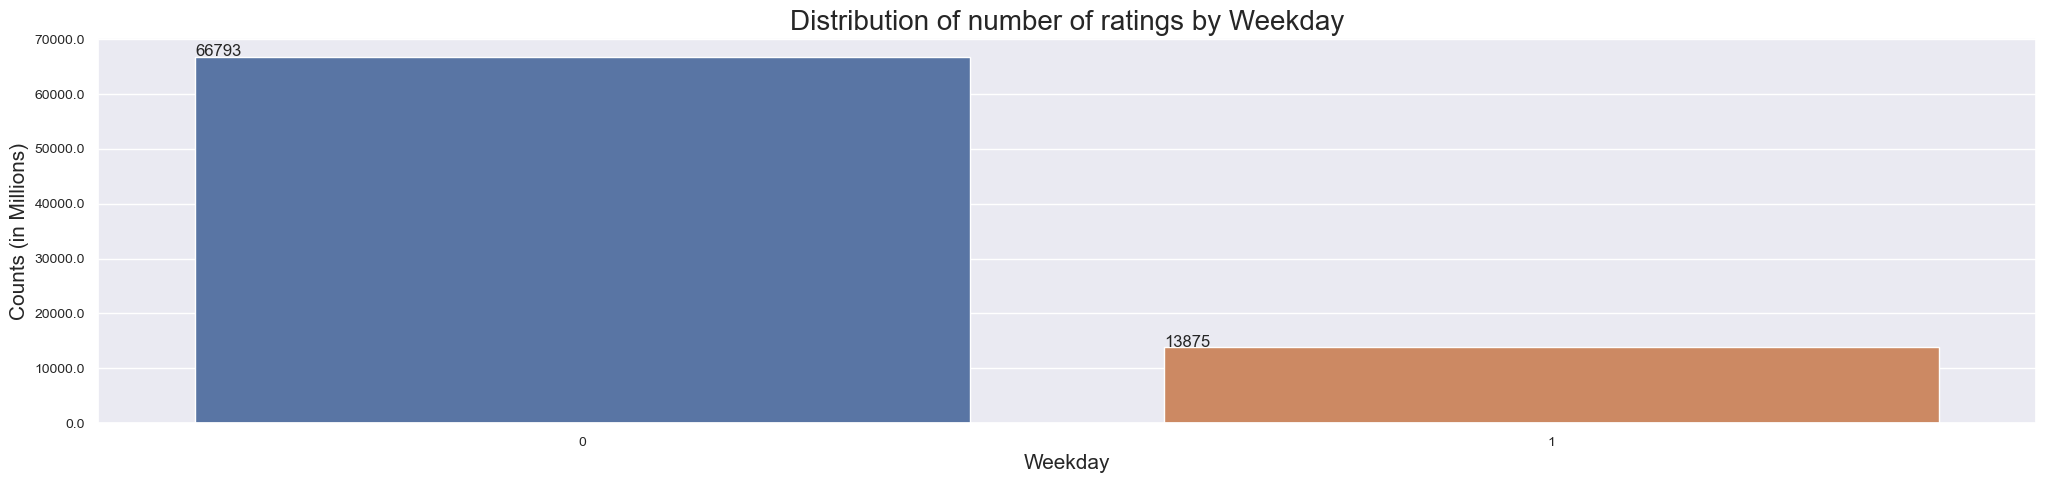

In [48]:
# Visualizing the count of ratings by weekday
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.barplot(x="Weekday", y="rating" , data=Train_Data.groupby(by=["Weekday"], as_index=False)["rating"].count(), ax=axes)
for p in axes.patches:
    axes.annotate('{}'.format(int(p.get_height())), (p.get_x(), p.get_height()+100))

axes.set_yticklabels([changingLabels(num) for num in axes.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Distribution of number of ratings by Weekday", fontsize = 20)
plt.xlabel("Weekday", fontsize = 15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel("Counts (in Millions)", fontsize = 15)
plt.show()

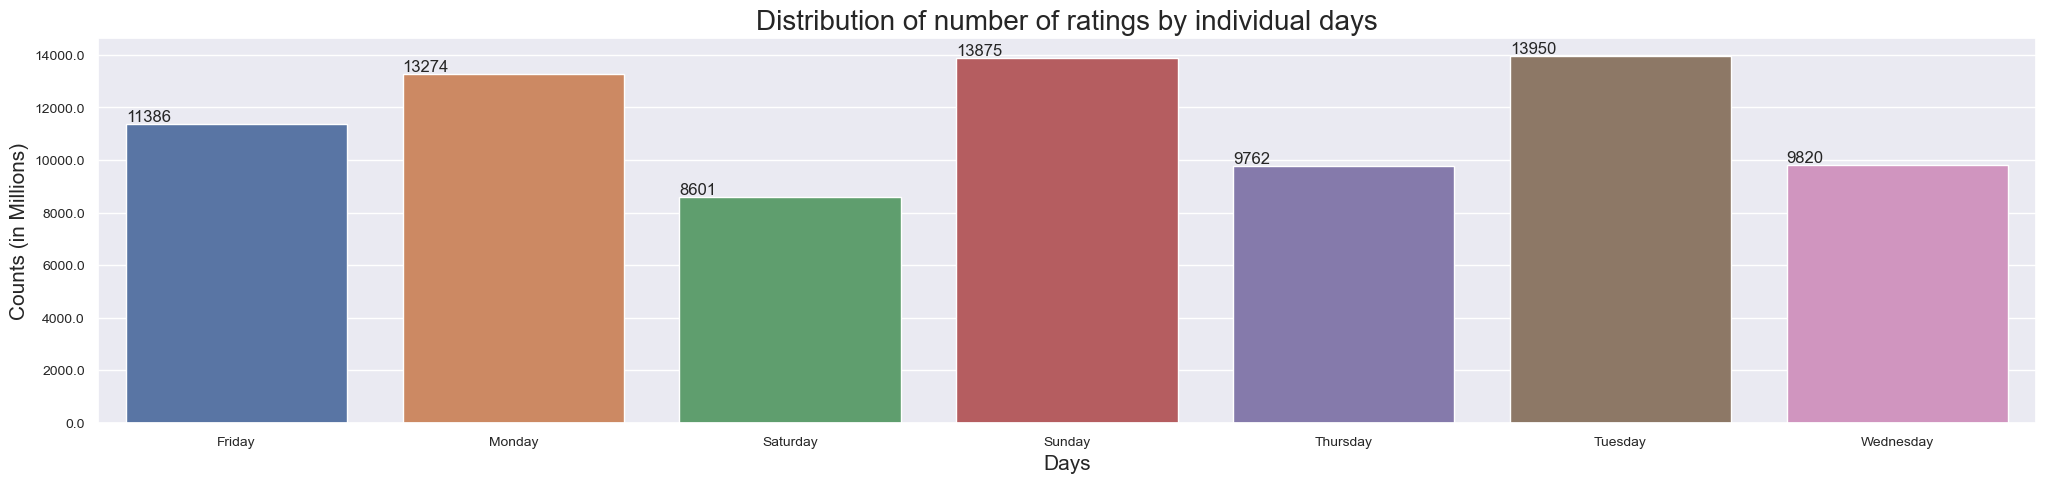

In [49]:
# Visualizing the count of ratings by individual days of the week
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.barplot(x="DayOfWeek", y="rating" , data=Train_Data.groupby(by=["DayOfWeek"], as_index=False)["rating"].count(), ax=axes)
for p in axes.patches:
    axes.annotate('{}'.format(int(p.get_height())), (p.get_x(), p.get_height()+100))

axes.set_yticklabels([changingLabels(num) for num in axes.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Distribution of number of ratings by individual days", fontsize = 20)
plt.xlabel("Days", fontsize = 15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel("Counts (in Millions)", fontsize = 15)
plt.show()

In [50]:
#Observations:

#1. The no. of ratings does not vary too much the days of the week.
#2. "Monday" and "Tuesday" clearly has more no. of ratings than any other days.
#3. The number of ratings in weekend is clearly extremly less than weekdays.

---

#####**3. Analyzing the average ratings by date.**

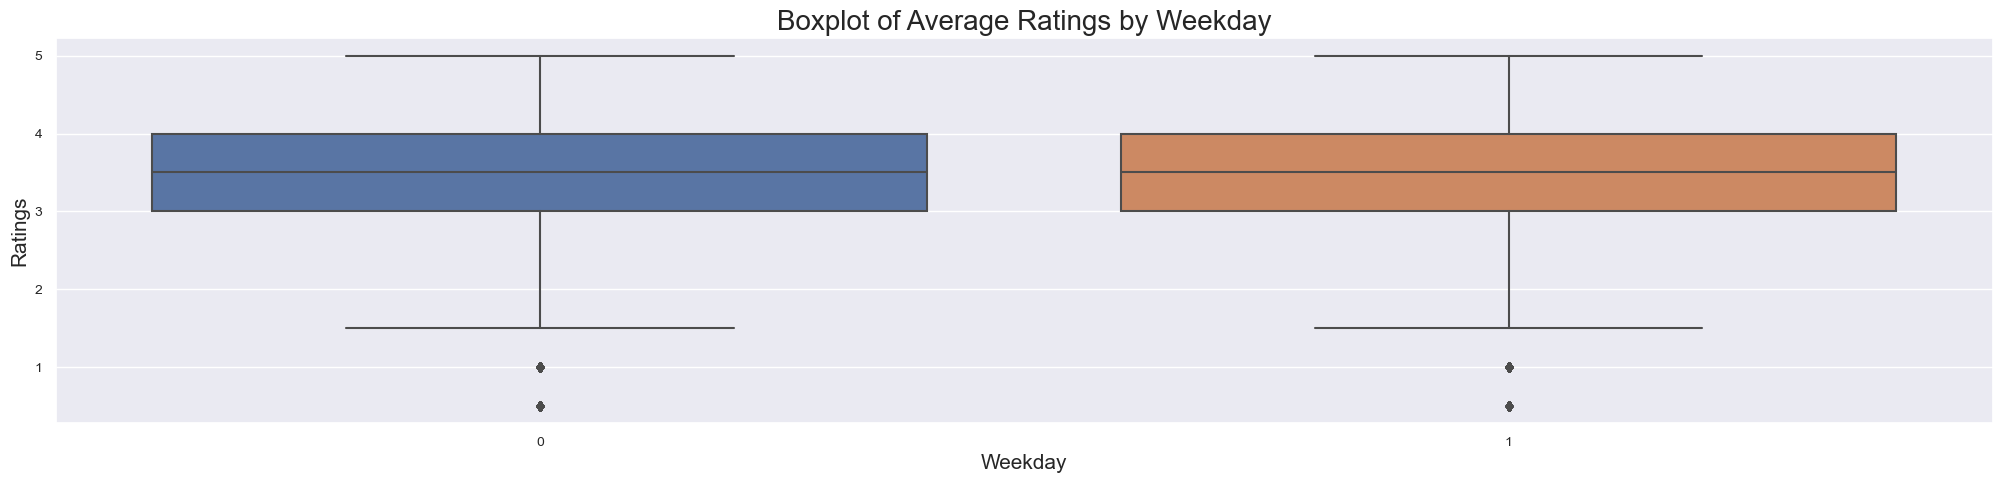

In [51]:
# Visualizing the average ratings by weekday
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.boxplot(x="Weekday", y="rating" , data=Train_Data, ax=axes)

plt.tick_params(labelsize = 15)
plt.title("Boxplot of Average Ratings by Weekday", fontsize = 20)
plt.xlabel("Weekday", fontsize = 15)
plt.xticks(fontsize=10)
plt.ylabel("Ratings", fontsize = 15)
plt.yticks(fontsize=10)
plt.show()

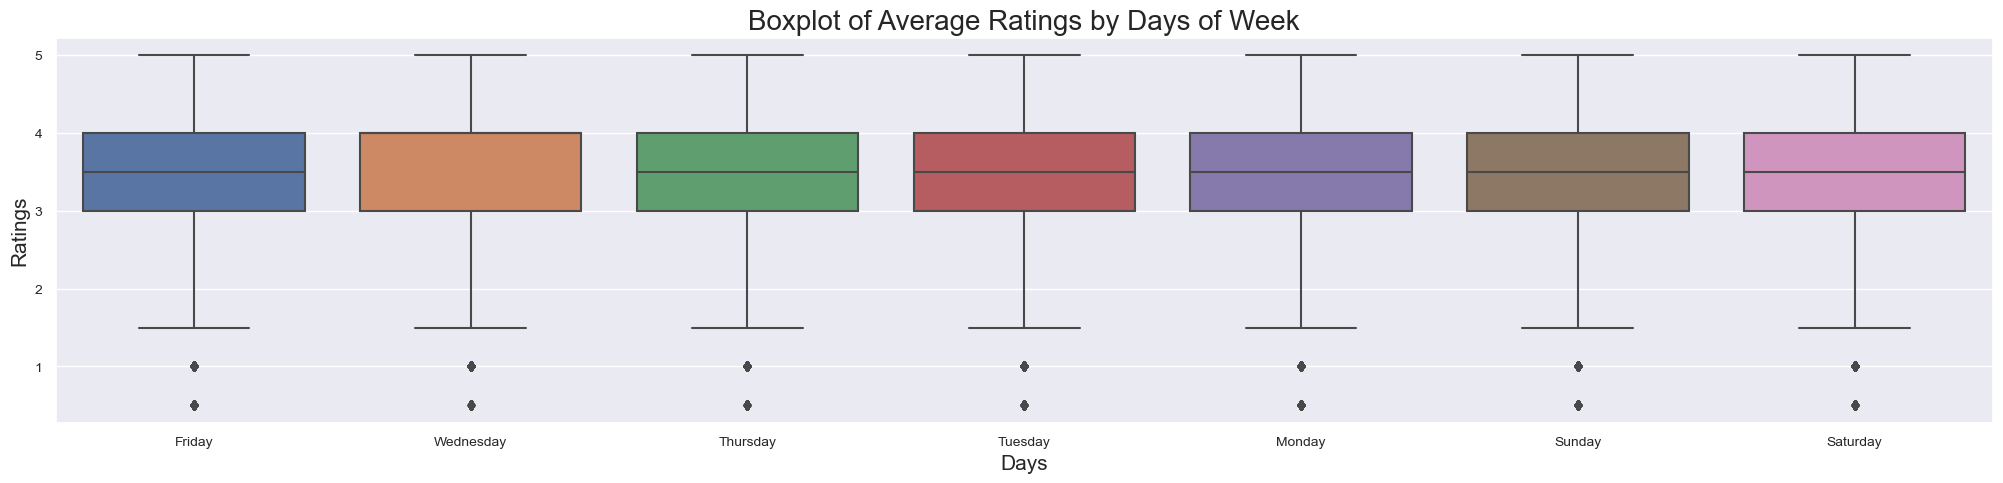

In [52]:
# Visualizing the average ratings by individual Days of the Week
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.boxplot(x="DayOfWeek", y="rating", data=Train_Data, ax=axes)

plt.tick_params(labelsize = 15)
plt.title("Boxplot of Average Ratings by Days of Week", fontsize = 20)
plt.xlabel("Days", fontsize = 15)
plt.xticks(fontsize=10)
plt.ylabel("Ratings", fontsize = 15)
plt.yticks(fontsize=10)
plt.show()

In [53]:
#Observations:

#1. The average ratings given by the user does not seem to differ by weekday and weekends.
#2. Even when we plot the average ratings by individual days, they seem to be similar for all the individual days.

---

#####**4. Analyzing the Ratings given by Users.**

In [54]:
# Calculating the number of ratings given by individual users
no_of_rated_movies_per_user = Train_Data.groupby(by=["userId"], as_index=False)["rating"].count().sort_values(by="rating", ascending=False)
no_of_rated_movies_per_user.reset_index(drop=True, inplace=True)

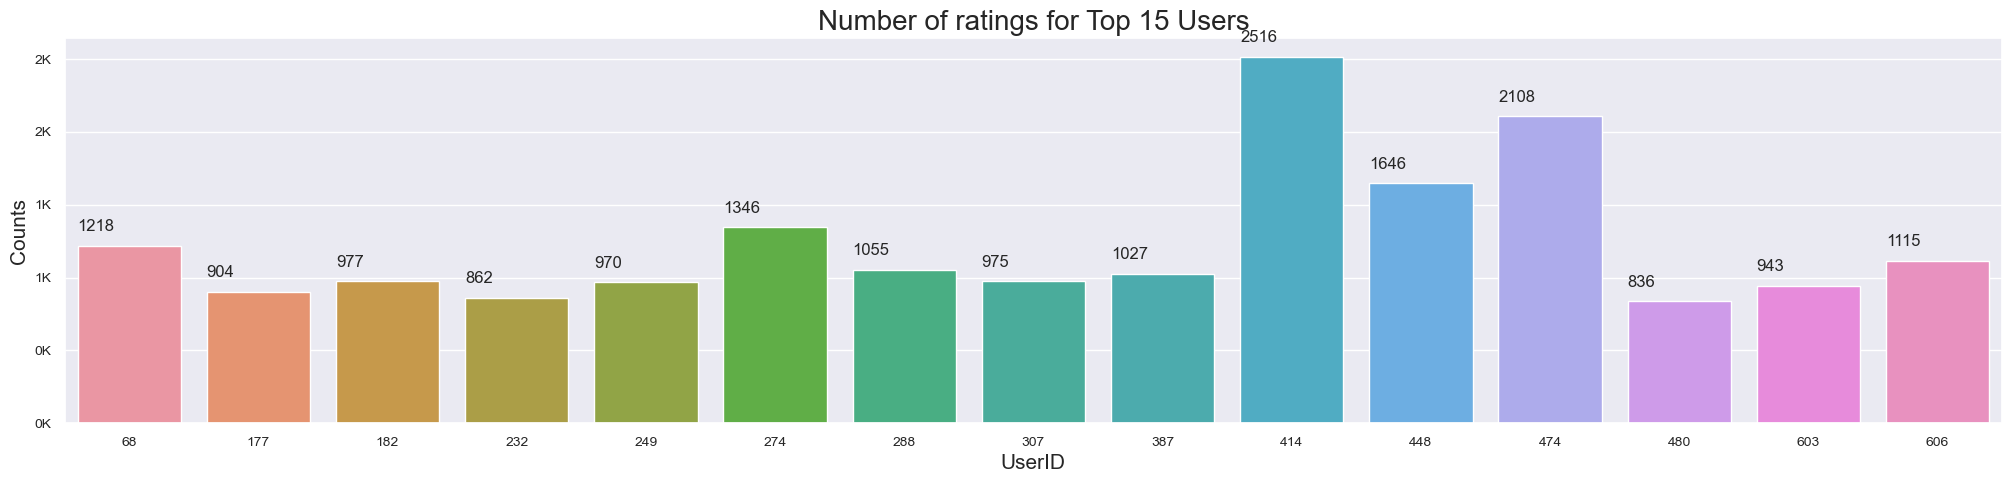

In [55]:
# Visualizing the count of ratings by individual users
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.barplot(x="userId", y="rating" , data=no_of_rated_movies_per_user[:15], ax=axes)
for p in axes.patches:
    axes.annotate('{}'.format(int(p.get_height())), (p.get_x(), p.get_height()+100))

axes.set_yticklabels([ChangingLabelsInK(num) for num in axes.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Number of ratings for Top 15 Users", fontsize = 20)
plt.xlabel("UserID", fontsize = 15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel("Counts", fontsize = 15)
plt.show()

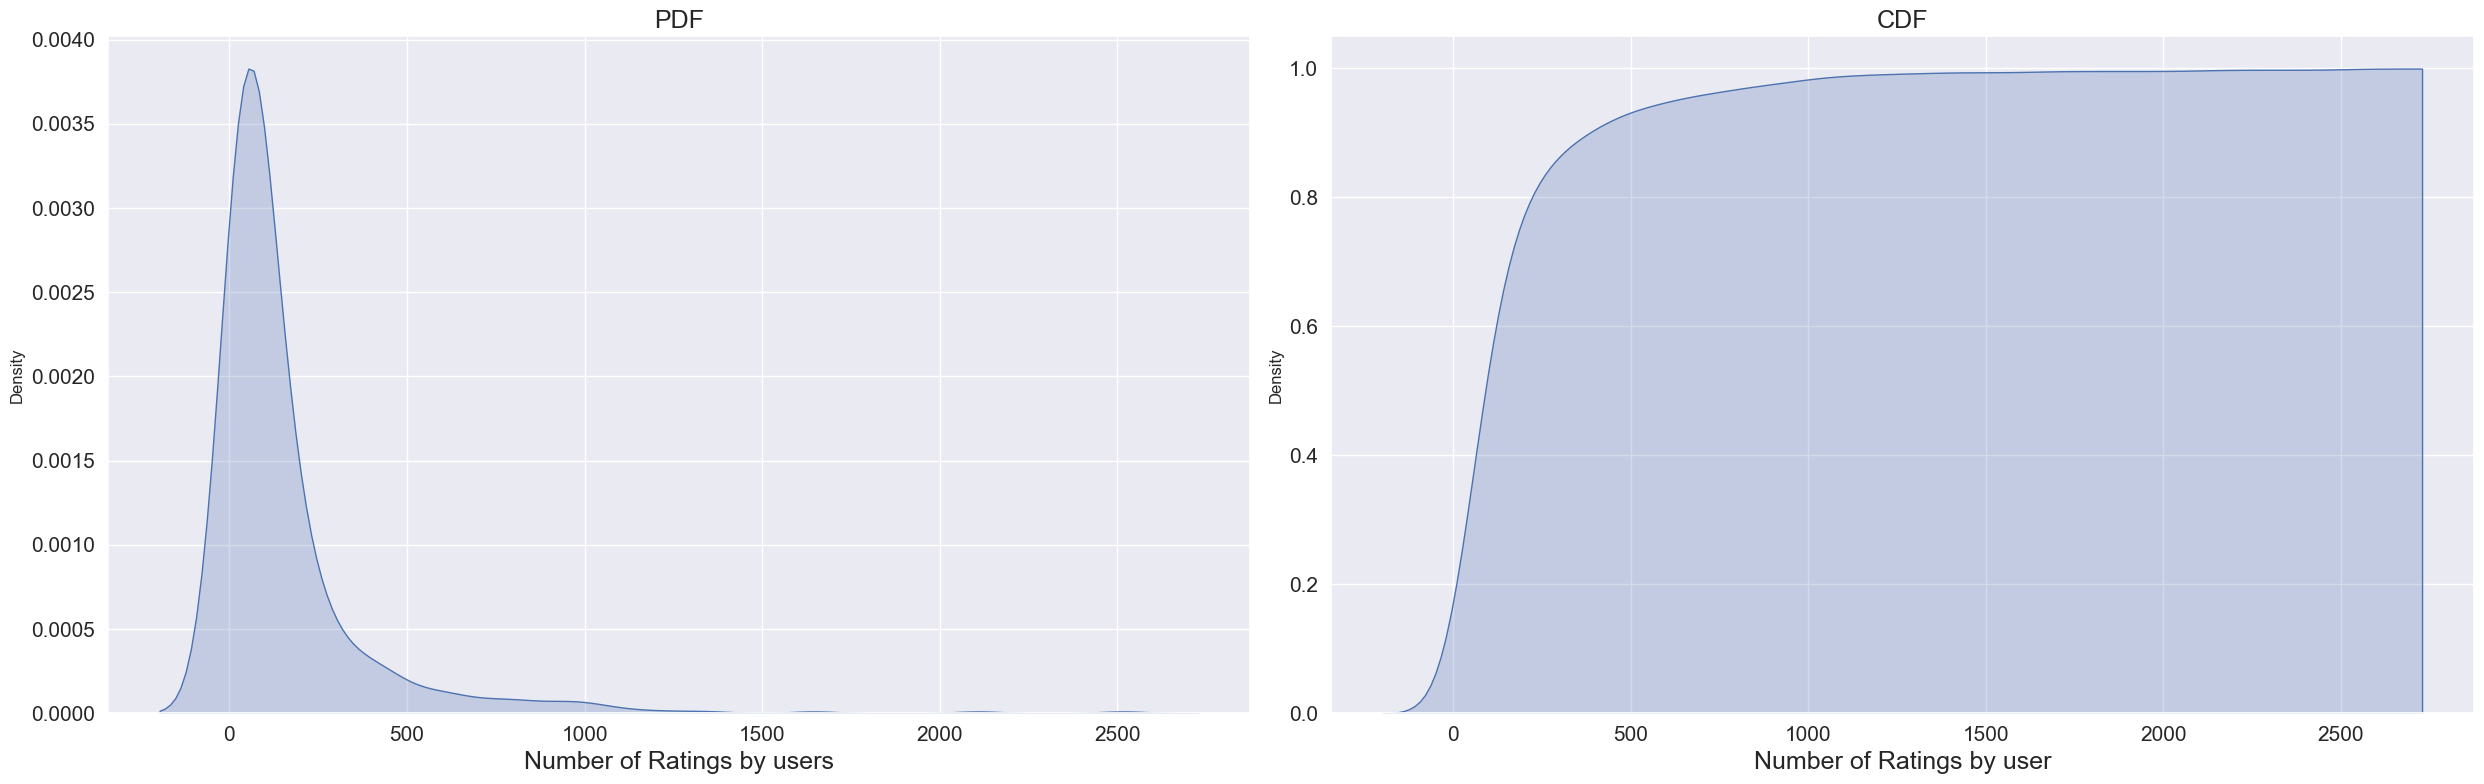

In [56]:
# Visualizing the count of ratings by individual users
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 2, figsize=(25, 8))

sns.kdeplot(no_of_rated_movies_per_user["rating"], shade = True, ax = axes[0])
axes[0].set_title("PDF", fontsize = 18)
axes[0].set_xlabel("Number of Ratings by users", fontsize = 18)
axes[0].tick_params(labelsize = 15)

sns.kdeplot(no_of_rated_movies_per_user["rating"], shade = True, cumulative = True, ax = axes[1])
axes[1].set_title("CDF", fontsize = 18)
axes[1].set_xlabel("Number of Ratings by user", fontsize = 18)
axes[1].tick_params(labelsize = 15)

fig.subplots_adjust(wspace=2)
plt.tight_layout()
plt.show()

In [57]:
# Checking the basic statistics for the number of ratings per user
print("Information about no. of ratings by users : \n", no_of_rated_movies_per_user["rating"].describe())

Information about no. of ratings by users : 
 count     522.000000
mean      154.536398
std       247.402723
min        16.000000
25%        35.000000
50%        67.500000
75%       159.750000
max      2516.000000
Name: rating, dtype: float64


In [58]:
quantiles = no_of_rated_movies_per_user["rating"].quantile(np.arange(0.9, 1.01,0.01))
qvalue = np.arange(0.9, 1.01,0.01)
for ctr in qvalue:
    print("The {}th quantile value is : {}".format(int(ctr*100), quantiles[ctr]))

The 90th quantile value is : 376.90000000000003
The 91th quantile value is : 400.33000000000004
The 92th quantile value is : 437.0
The 93th quantile value is : 468.06000000000006
The 94th quantile value is : 525.1399999999994
The 95th quantile value is : 607.5999999999999
The 96th quantile value is : 707.000000000002
The 97th quantile value is : 807.6900000000044
The 98th quantile value is : 958.6600000000011
The 99th quantile value is : 1102.4000000000046
The 100th quantile value is : 2516.0


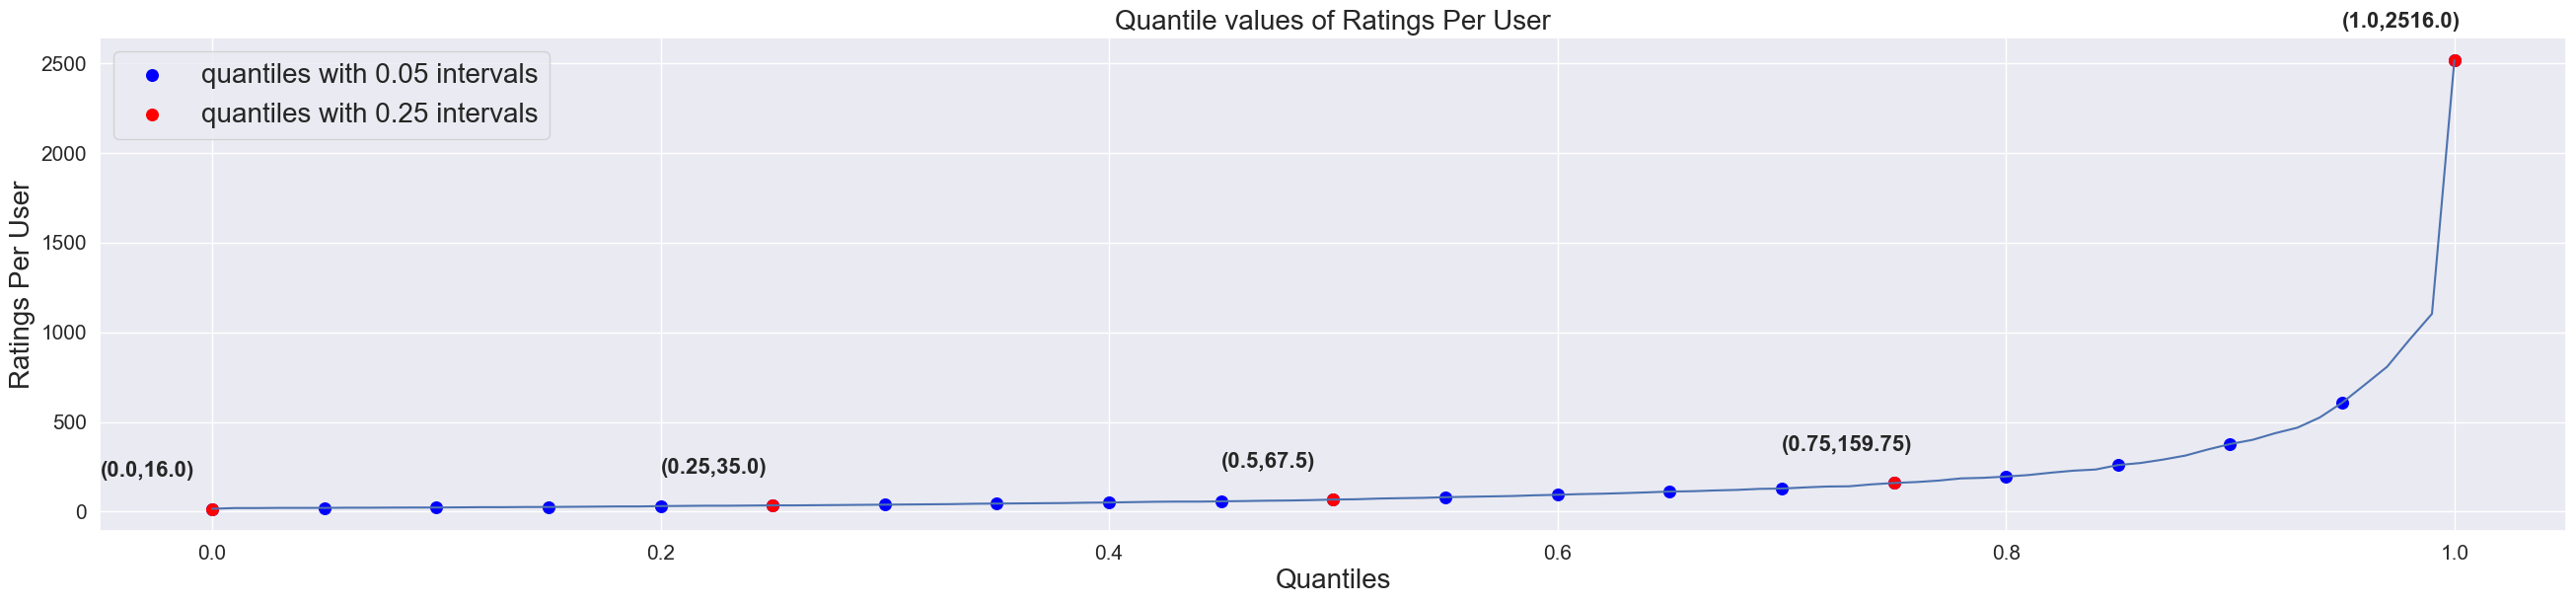

In [59]:
import matplotlib.pyplot as plt
import numpy as np

quantiles = no_of_rated_movies_per_user["rating"].quantile(np.arange(0, 1.01, 0.01))

fig = plt.figure(figsize=(25, 5))

axes = fig.add_axes([0.1, 0.1, 1, 1])
axes.set_title("Quantile values of Ratings Per User", fontsize=20)
axes.set_xlabel("Quantiles", fontsize=20)
axes.set_ylabel("Ratings Per User", fontsize=20)
axes.plot(quantiles)

plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c="blue", s=70, label="quantiles with 0.05 intervals")
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c="red", s=70, label="quantiles with 0.25 intervals")
plt.legend(loc='upper left', fontsize=20)

for x, y in zip(quantiles.index[::25], quantiles.values[::25]):
    plt.annotate(text='({},{})'.format(x, y), xy=(x, y), fontweight='bold', fontsize=16, xytext=(x-0.05, y+180))

axes.tick_params(labelsize=15)
plt.show()


In [60]:
#Observations:

#1. The top 10 users tend to have rated more than 4K times, which seems bit extreme behaviour.
#2. The userId 118205 has rated over 7K+ times, which seems surprising.
#3. From the KDE plot, it is clearly evident that the number of ratings is highly right skewed, and most of the user's ratings is between 0-1000.
#4. Similarly, above CDF graph shows that almost 99% of users give very few ratings.
#5. The mean no. of ratings a user gives is 142 while the median is 69.
#6. The no. of movies start to increase drastically from 90th percentile.

In [61]:
# Calculating average ratings given by individual users
avg_ratings_per_user = Train_Data.groupby(by = ["userId"], as_index=False)["rating"].mean()
avg_ratings_per_user = avg_ratings_per_user.reset_index(drop=True)
avg_ratings_per_user = avg_ratings_per_user.merge(no_of_rated_movies_per_user[["userId", "rating"]], how="left", on="userId")
avg_ratings_per_user.rename(columns={"rating_x":"avg_rating", "rating_y": "num_of_rating"}, inplace=True)
avg_ratings_per_user = avg_ratings_per_user.sort_values("num_of_rating", ascending=False)

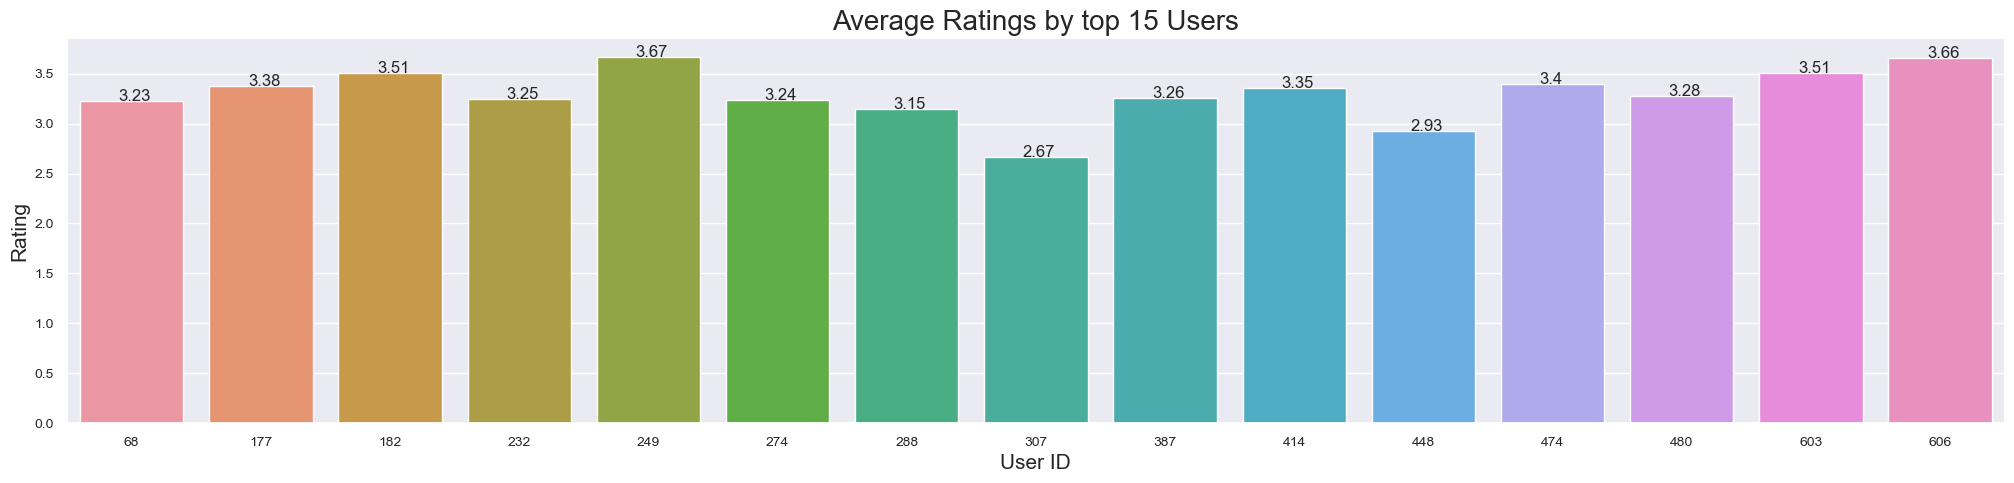

In [62]:
# Visualizing the average ratings by individual Days of the Week
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.barplot(x="userId", y="avg_rating", data=avg_ratings_per_user[:15], ax=axes)

for p in axes.patches:
    axes.annotate('{}'.format(round(p.get_height(), 2)), (p.get_x()+0.3, p.get_height()))

plt.tick_params(labelsize = 15)
plt.title("Average Ratings by top 15 Users", fontsize = 20)
plt.xlabel("User ID", fontsize = 15)
plt.xticks(fontsize=10)
plt.ylabel("Rating", fontsize = 15)
plt.yticks(fontsize=10)
plt.show()

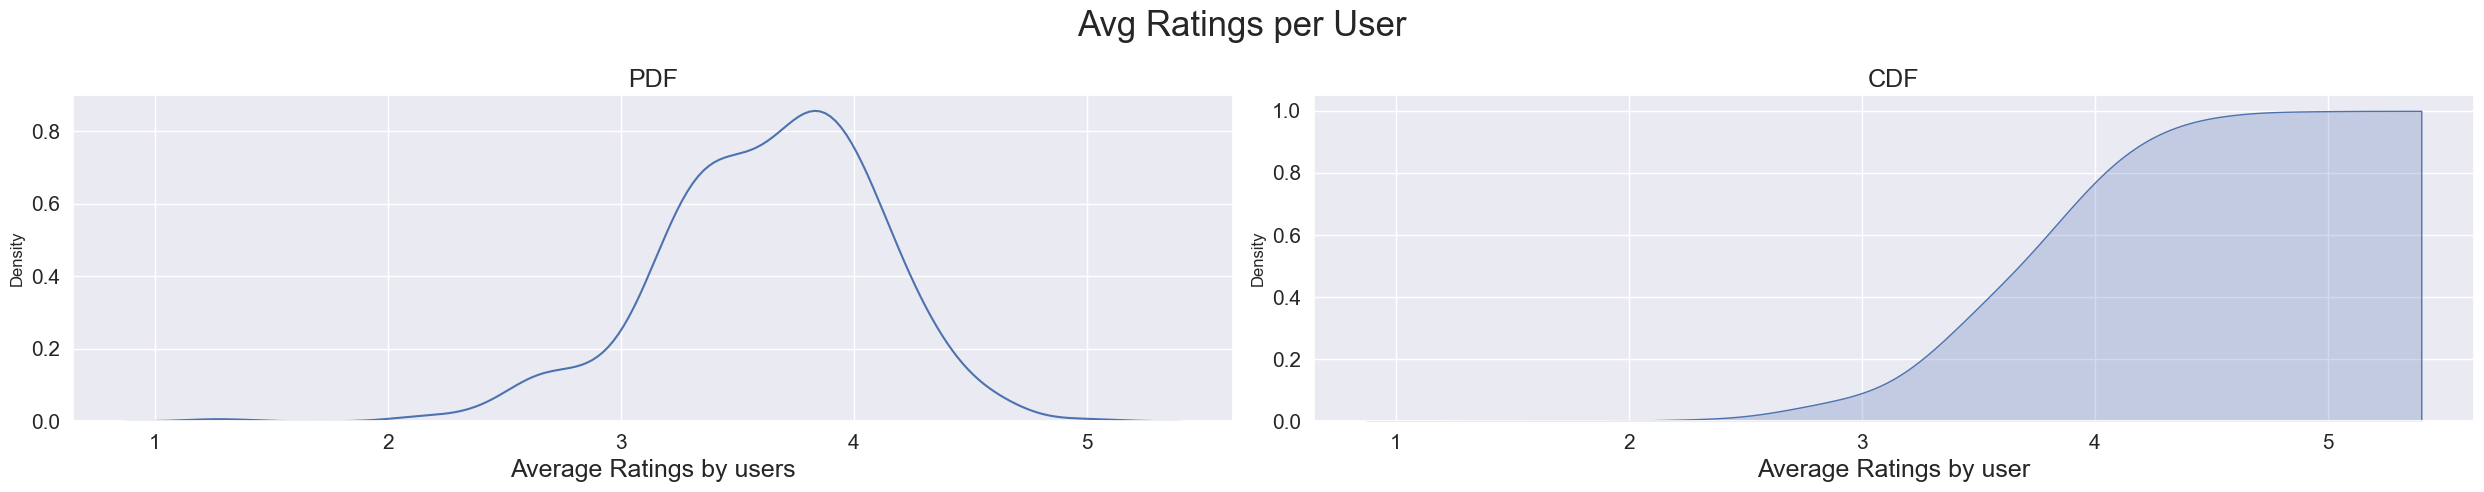

In [63]:
# Plotting the PDF and CDF for Avg. rating by Users
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 2, figsize=(25, 5))
fig.suptitle("Avg Ratings per User", fontsize=25)

sns.distplot(avg_ratings_per_user["avg_rating"], hist = False, ax = axes[0], label = "PDF")
axes[0].set_title("PDF", fontsize = 18)
axes[0].set_xlabel("Average Ratings by users", fontsize = 18)
axes[0].tick_params(labelsize = 15)

sns.kdeplot(avg_ratings_per_user["avg_rating"], cumulative = True, ax = axes[1], shade=True, label = "CDF")
axes[1].set_title("CDF", fontsize = 18)
axes[1].set_xlabel("Average Ratings by user", fontsize = 18)
axes[1].tick_params(labelsize = 15)

fig.subplots_adjust(wspace=2)
plt.tight_layout()
plt.show()

In [64]:
#Observations:

#1. User ID 125794 has the highest avg. rating of 3.81.
#2. The pdf of average ratings given by a user seems to be a bit left skewed, with most of the values centered around 3.5 to 4.
#3. THe cdf also shows that avg. ratings is most frequent in between 3 to 5. 

---

#####**5. Analyzing the Ratings given to the Movies.**

In [65]:
# Calculating count of ratings received for movies

no_of_ratings_per_movie = Train_Data.groupby(by = ["movieId", "title"], as_index=False)["rating"].count().sort_values(by=["rating"], ascending = False)
no_of_ratings_per_movie = no_of_ratings_per_movie.reset_index(drop=True)

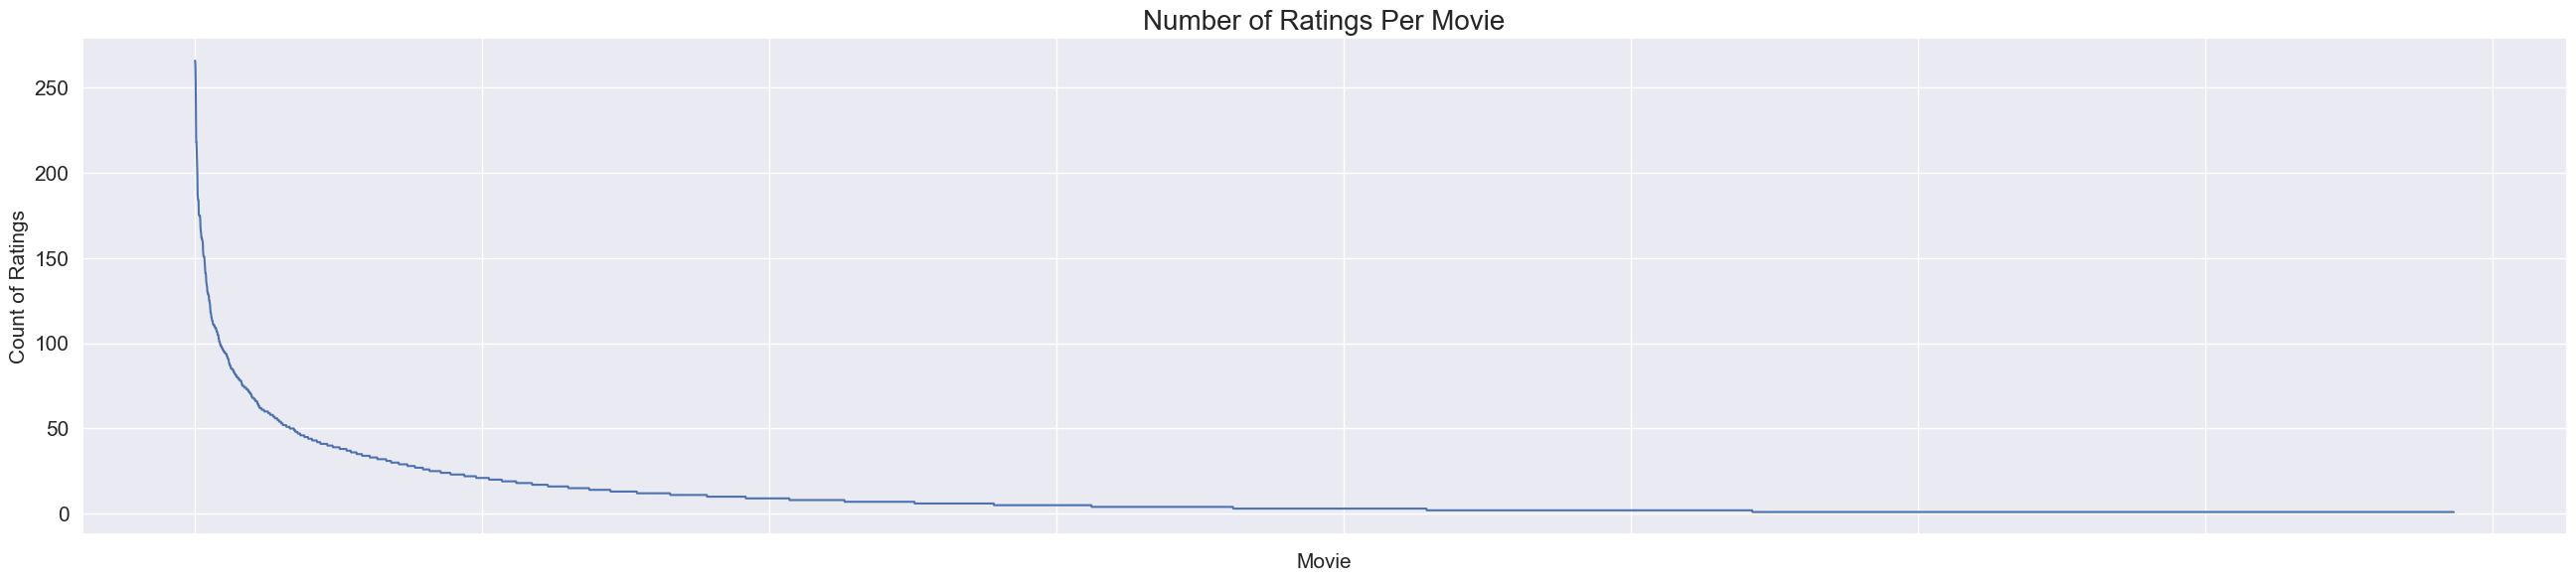

In [66]:
# Visualizing the number of ratings for the movies

sns.set(style="darkgrid")

fig = plt.figure(figsize = (25, 5))
axes = fig.add_axes([0.1, 0.1, 1, 1])
plt.title("Number of Ratings Per Movie", fontsize = 20)
plt.xlabel("Movie", fontsize = 15)
plt.ylabel("Count of Ratings", fontsize = 15)

plt.plot(no_of_ratings_per_movie["rating"].values)

plt.tick_params(labelsize = 15)
axes.set_xticklabels([])
plt.show()

In [67]:
#Observations:

#1. It is quite clear that there are some movies which are very popular and were rated by many users as comapared to other movies which has caused the plot to be skewed.



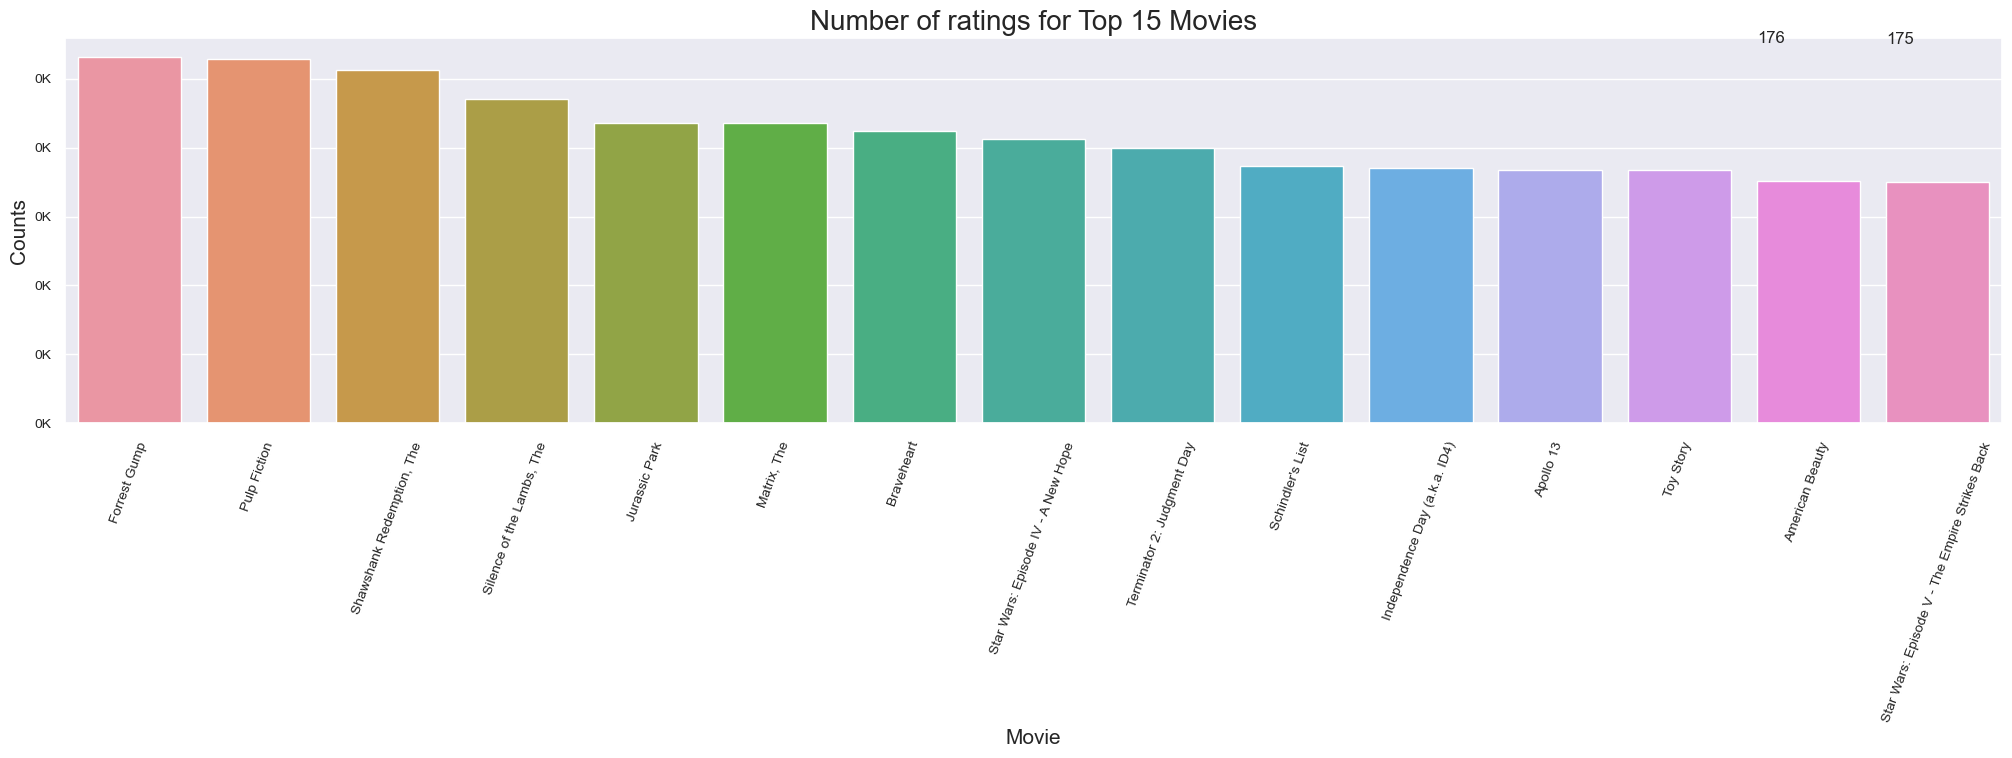

In [68]:
# Visualizing top 5 movies heavily rated movies.

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.barplot(x="title", y="rating", data=no_of_ratings_per_movie[:15], ax=axes)
for p in axes.patches:
    axes.annotate('{}'.format(int(p.get_height())), (p.get_x(), p.get_height()+100))

axes.set_yticklabels([ChangingLabelsInK(num) for num in axes.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Number of ratings for Top 15 Movies", fontsize = 20)
plt.xlabel("Movie", fontsize = 15)
plt.xticks(rotation=70, fontsize=10)
plt.ylabel("Counts", fontsize = 15)
plt.yticks(fontsize=10)
plt.show()

In [69]:
# Calculating average ratings for movies

avg_ratings_per_movie = Train_Data.groupby(by = ["movieId", "title"], as_index=False)["rating"].mean()
avg_ratings_per_movie = avg_ratings_per_movie.reset_index(drop=True)
avg_ratings_per_movie = avg_ratings_per_movie.merge(no_of_ratings_per_movie[["movieId", "rating"]], how="left", on="movieId")
avg_ratings_per_movie.rename(columns={"rating_x":"avg_rating", "rating_y": "num_of_rating"}, inplace=True)
avg_ratings_per_movie = avg_ratings_per_movie.sort_values("num_of_rating", ascending=False)

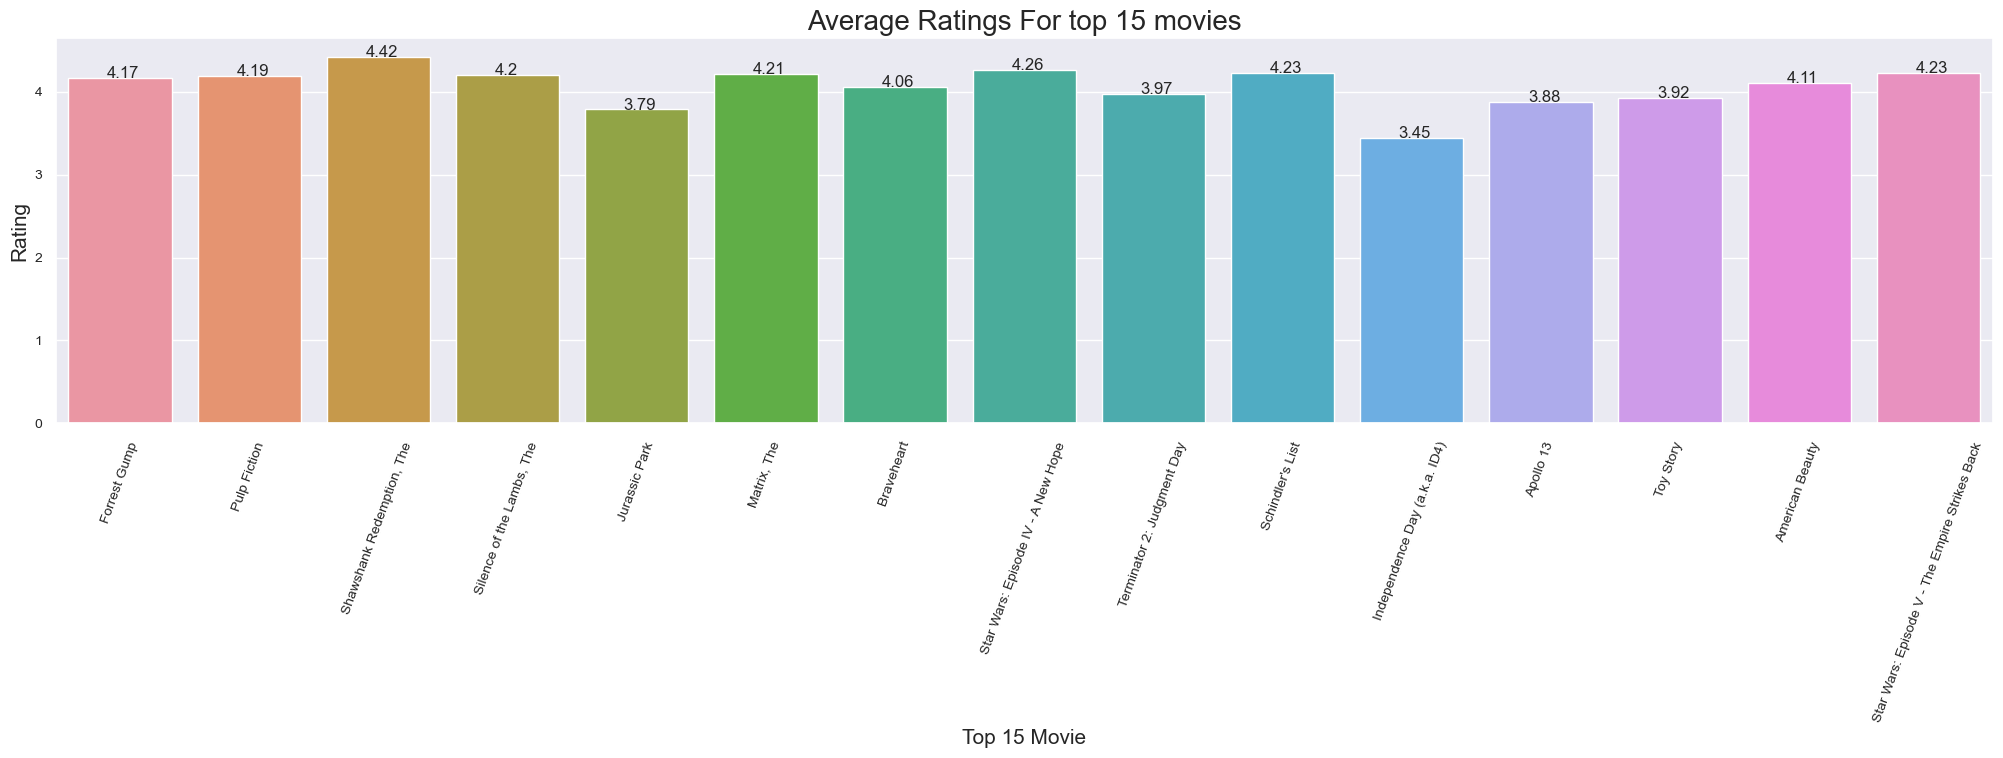

In [70]:
# Visualizing the average ratings by individual Days of the Week

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)

sns.barplot(x="title", y="avg_rating", data=avg_ratings_per_movie[:15], ax=axes)

for p in axes.patches:
    axes.annotate('{}'.format(round(p.get_height(), 2)), (p.get_x()+0.3, p.get_height()))

plt.tick_params(labelsize = 15)
plt.title("Average Ratings For top 15 movies", fontsize = 20)
plt.xlabel("Top 15 Movie", fontsize = 15)
plt.xticks(rotation=70, fontsize=10)
plt.ylabel("Rating", fontsize = 15)
plt.yticks(fontsize=10)
plt.show()

In [71]:
#Observations:

#1. The cult movies form 1990s have been rated the most.
#2. Pulp Fiction, Forrest Gump, Shawshank Redemption and Silience of the Lambs have been rated over 50K times.
#3. Shawshank Redemption has the highest average rating of 4.56 based on 50K+ ratings.

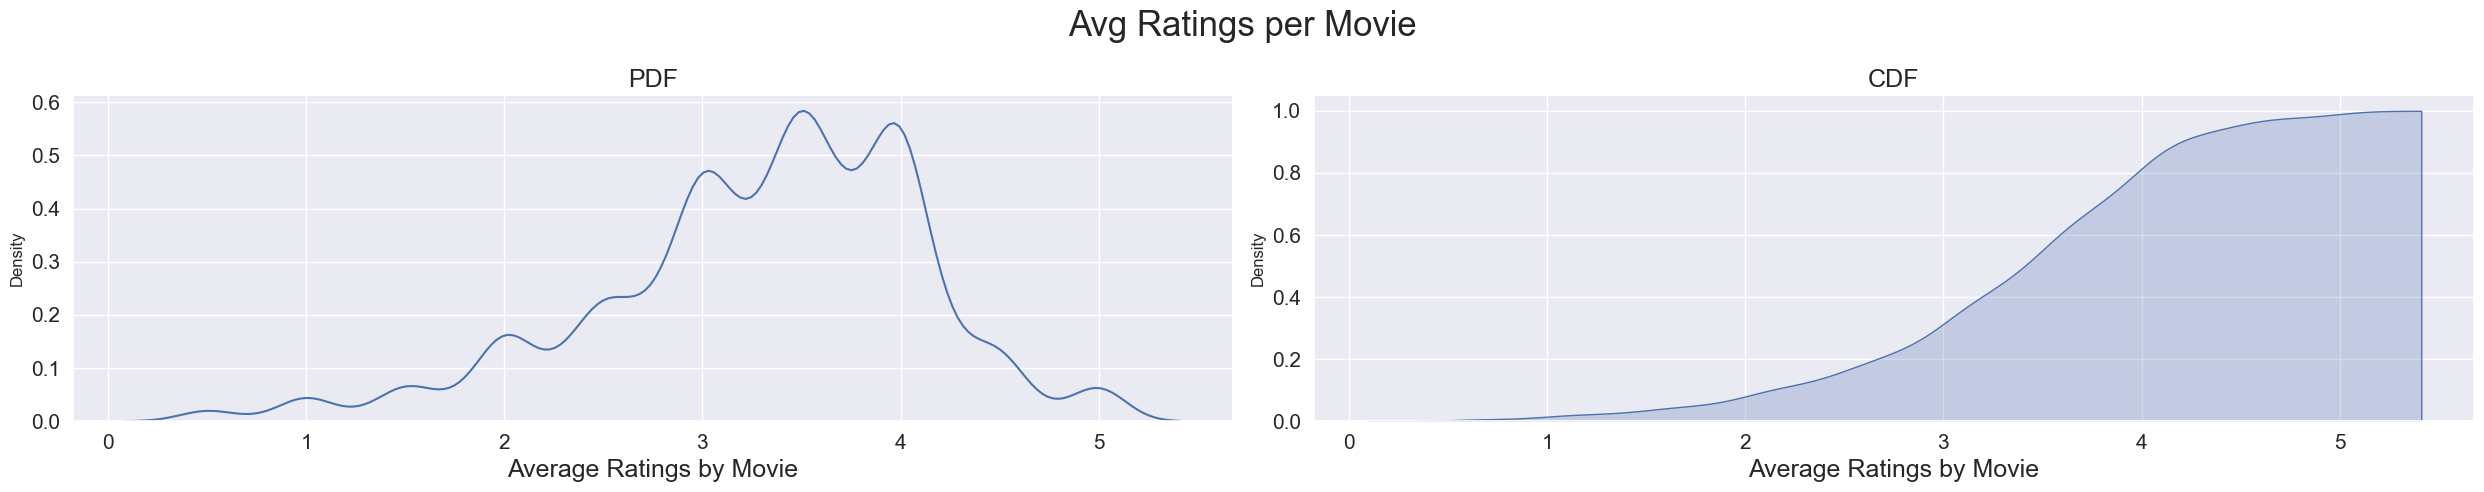

In [72]:
# Plotting the PDF and CDF for Avg. rating by Movies

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 2, figsize=(25, 5))
fig.suptitle("Avg Ratings per Movie", fontsize=25)

sns.distplot(avg_ratings_per_movie["avg_rating"], hist = False, ax = axes[0], label = "PDF")
axes[0].set_title("PDF", fontsize = 18)
axes[0].set_xlabel("Average Ratings by Movie", fontsize = 18)
axes[0].tick_params(labelsize = 15)

sns.kdeplot(avg_ratings_per_movie["avg_rating"], cumulative = True, ax = axes[1], shade=True, label = "CDF")
axes[1].set_title("CDF", fontsize = 18)
axes[1].set_xlabel("Average Ratings by Movie", fontsize = 18)
axes[1].tick_params(labelsize = 15)

fig.subplots_adjust(wspace=2)
plt.tight_layout()
plt.show()

In [73]:
#Observations:

#1. The distribution of average rating for movie is fairly normal one. 
#2. The cdf shows that the avg. rating is more frequent after 3.

In [74]:
Train_Data.head()

,userId,movieId,rating,date,title,genres,DayOfWeek,Weekday
0,429,507,5.0,1996-03-29,Aladdin,Adventure|Animation|Children|Comedy|Musical,Friday,0
1,429,204,4.0,1996-03-29,Forget Paris,Comedy|Romance,Friday,0
2,429,203,4.0,1996-03-29,French Kiss,Action|Comedy|Romance,Friday,0
3,429,201,2.0,1996-03-29,Exit to Eden,Comedy,Friday,0
4,429,194,3.0,1996-03-29,Drop Zone,Action|Thriller,Friday,0


# 3. Feature Engineering 


#### ** Creating Matrices**

We will be creating matrices like: User-Item matrix, User-User and Item-Item similarity matrix.

---

#####**1. Creating USER-ITEM sparse matrix.**

In [75]:
# Path for loading/saving files

file_path = "/content/drive/MyDrive/Colab Datasets/Movie Recommendation"

In [76]:
from datetime import datetime
import os
from scipy import sparse

# Define startTime
startTime = datetime.now()

# Round the ratings to the nearest integer
Train_Data["rating"] = Train_Data["rating"].round().astype(int)

if os.path.isfile("TrainUISparseData.npz"):
    print("Sparse Data is already present on your disk. Loading Sparse Matrix...")
    TrainUISparseData = sparse.load_npz("TrainUISparseData.npz")
    print("Shape of Train Sparse Matrix: ", TrainUISparseData.shape)
else:
    print("Creating sparse data...")
    TrainUISparseData = sparse.csr_matrix((Train_Data.rating, (Train_Data.userId, Train_Data.movieId)))
    print("Creation done. Shape of sparse matrix: ", TrainUISparseData.shape)
    print("Saving it onto disk for further usage.")
    sparse.save_npz("TrainUISparseData.npz", TrainUISparseData)
    print("Done")
    
print("Time taken:", datetime.now() - startTime)


Sparse Data is already present on your disk. Loading Sparse Matrix...
Shape of Train Sparse Matrix:  (610, 9246)
Time taken: 0:00:00.012001


In [77]:
rows,cols = TrainUISparseData.shape
presentElements = TrainUISparseData.count_nonzero()

print("Sparsity Of Train matrix : {}% ".format((1-(presentElements/(rows*cols)))*100))

Sparsity Of Train matrix : 98.58669943227555% 


In [78]:
# Creating/loading user-movie sparse matrix for test data

startTime = datetime.now()

print("Creating USER_ITEM sparse matrix for test Data..")

if os.path.isfile("TestUISparseData.npz"):
    print("Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix")
    TestUISparseData = sparse.load_npz("TestUISparseData.npz")
    print("Shape of Test Sparse Matrix : ", str(TestUISparseData.shape))
else:
    print("We are creating sparse data..")
    # Assuming Test_Data is defined
    TestUISparseData = sparse.csr_matrix((Test_Data.rating, (Test_Data.userId, Test_Data.movieId)))
    print("Creation done. Shape of sparse matrix : ", str(TestUISparseData.shape))
    print("Saving it into disk for further usage.")
    sparse.save_npz("TestUISparseData.npz", TestUISparseData)
    print("Done\n")

print("Time Taken : ", datetime.now() - startTime)

Creating USER_ITEM sparse matrix for test Data..
Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix
Shape of Test Sparse Matrix :  (611, 9743)
Time Taken :  0:00:00.006806


In [79]:
rows,cols = TestUISparseData.shape
presentElements = TestUISparseData.count_nonzero()

print("Sparsity Of Test matrix : {}% ".format((1-(presentElements/(rows*cols)))*100))

Sparsity Of Test matrix : 99.66121129727952% 


In [80]:
#Observations:

#1. Shape of sparse matrix depends on highest value of userId and highest value of movieId. 
#2. In the test set, there are few users from train set which is not present in the test set. 
#3. For the movieId, there are less movies in the train set as compared to test set. The reason stems from the fact that we split the data based on time, and newer movies would have fallen into test set.
#4. The sparsity of train set is 99.19% while the sparsity of test set is 99.89%.

In [81]:
# Function to Calculate Average rating for users or movies from User-movie sparse matrix
 
def getAverageRatings(sparseMatrix, if_user):

    #axis = 1 means rows and axis = 0 means columns 
    ax = 1 if if_user else 0

    sumOfRatings = sparseMatrix.sum(axis = ax).A1  
    noOfRatings = (sparseMatrix!=0).sum(axis = ax).A1  
    rows, cols = sparseMatrix.shape
    averageRatings = {i: sumOfRatings[i]/noOfRatings[i] for i in range(rows if if_user else cols) if noOfRatings[i]!=0}
    
    return averageRatings

In [82]:
AvgRatingUser = getAverageRatings(TrainUISparseData, True)
AvgRatingMovie = getAverageRatings(TrainUISparseData, False)
train_users = len(AvgRatingUser)
uncommonUsers = total_users - train_users
                  
print("Total no. of Users : ", total_users)
print("No. of Users in Train data : ", train_users)
print("No. of Users not present in Train data : {}({}%)".format(uncommonUsers, np.round((uncommonUsers/total_users)*100), 2))

Total no. of Users :  610
No. of Users in Train data :  522
No. of Users not present in Train data : 88(14.0%)


In [83]:
train_movies = len(AvgRatingMovie)
uncommonMovies = total_movies - train_movies
                  
print("Total no. of Movies : ", total_movies)
print("No. of Movies in Train data : ", train_movies)
print("No. of Movies not present in Train data = {}({}%)".format(uncommonMovies, np.round((uncommonMovies/total_movies)*100), 2))

Total no. of Movies :  9724
No. of Movies in Train data :  7815
No. of Movies not present in Train data = 1909(20.0%)


In [84]:
#Observations:

#1. Recommendation System suffers from Cold Start problems, which needs to be tackled wisely in order to design a effective system.
#2. There are 26027, ie 19% of the users are not present in the training data.
#3. There are 12387, ie 54% of the movies which are not present in the training data.

---

#####**2. Creating Similarity Matrix**




---

**2.1. Computing Item-Item Similarity Matrix**

In [85]:
# Computing item item similarity matrix for the train data

start = datetime.now()

print("Movie-Movie Similarity file does not exist in your disk. Creating Movie-Movie Similarity Matrix...")
if not os.path.isfile("m_m_similarity.npz"):
    m_m_similarity = cosine_similarity(TrainUISparseData.T, dense_output=False)
    print("Dimension of Matrix : ", m_m_similarity.shape)
    print("Storing the Movie Similarity matrix on disk for further usage")
    sparse.save_npz("m_m_similarity.npz", m_m_similarity)
else:
    print("File exists in the disk. Loading the file...")
    m_m_similarity = sparse.load_npz("m_m_similarity.npz")
    print("Dimension of Matrix : ", m_m_similarity.shape)

print("The time taken to compute movie-movie similarity matrix is : ", datetime.now() - start)

Movie-Movie Similarity file does not exist in your disk. Creating Movie-Movie Similarity Matrix...
File exists in the disk. Loading the file...
Dimension of Matrix :  (9246, 9246)
The time taken to compute movie-movie similarity matrix is :  0:00:01.645845


In [86]:
# Creating a function to take Movie Name and generate the top matched name and generate its N similar movies based on M-M Similary

def GetSimilarMoviesUsingMovieMovieSimilarity(movie_name, num_of_similar_movies):
    matches = process.extract(movie_name, movie_list_in_training["title"], scorer=fuzz.partial_ratio)
    if len(matches) == 0:
        return "No Match Found"
    movie_id = movie_list_in_training.iloc[matches[0][2]]["movieId"]
    similar_movie_id_list = np.argsort(-m_m_similarity[movie_id].toarray().ravel())[0:num_of_similar_movies+1]
    sm_df = movie_list_in_training[movie_list_in_training["movieId"].isin(similar_movie_id_list)]
    sm_df["order"] = sm_df.apply(lambda x: list(similar_movie_id_list).index(x["movieId"]), axis=1)
    
    return sm_df.sort_values("order")

In [87]:
# Picking random movie and checking it's top 10 most similar movies

GetSimilarMoviesUsingMovieMovieSimilarity("Get Shorty (1995)", 10)

,movieId,title,genres,order
84,21,Get Shorty,Comedy|Crime|Thriller,0
166,399,"Fugitive, The",Thriller,1
202,384,Dave,Comedy|Romance,2
256,316,Four Weddings and a Funeral,Comedy|Romance,3
261,473,Sleepless in Seattle,Comedy|Drama|Romance,4
37,338,True Lies,Action|Adventure|Comedy|Romance|Thriller,5
251,413,In the Line of Fire,Action|Thriller,6
128,258,Pulp Fiction,Comedy|Crime|Drama|Thriller,7
57,261,Quiz Show,Drama,8
24,510,Batman,Action|Crime|Thriller,9


---

**3. Computing User-User Similarity Matrix.**



In [88]:
# Getting highest uder id

row_index, col_index = TrainUISparseData.nonzero()
unique_user_id = np.unique(row_index)

print("Max User id is :", np.max(unique_user_id))

Max User id is : 609


Time elapsed for 20 users = 0:00:00.100251sec
Time elapsed for 40 users = 0:00:00.196954sec
Time elapsed for 60 users = 0:00:00.287697sec
Time elapsed for 80 users = 0:00:00.386782sec
Time elapsed for 100 users = 0:00:00.484814sec
Average Time taken to compute similarity matrix for 1 user = 0.004803521633148193seconds


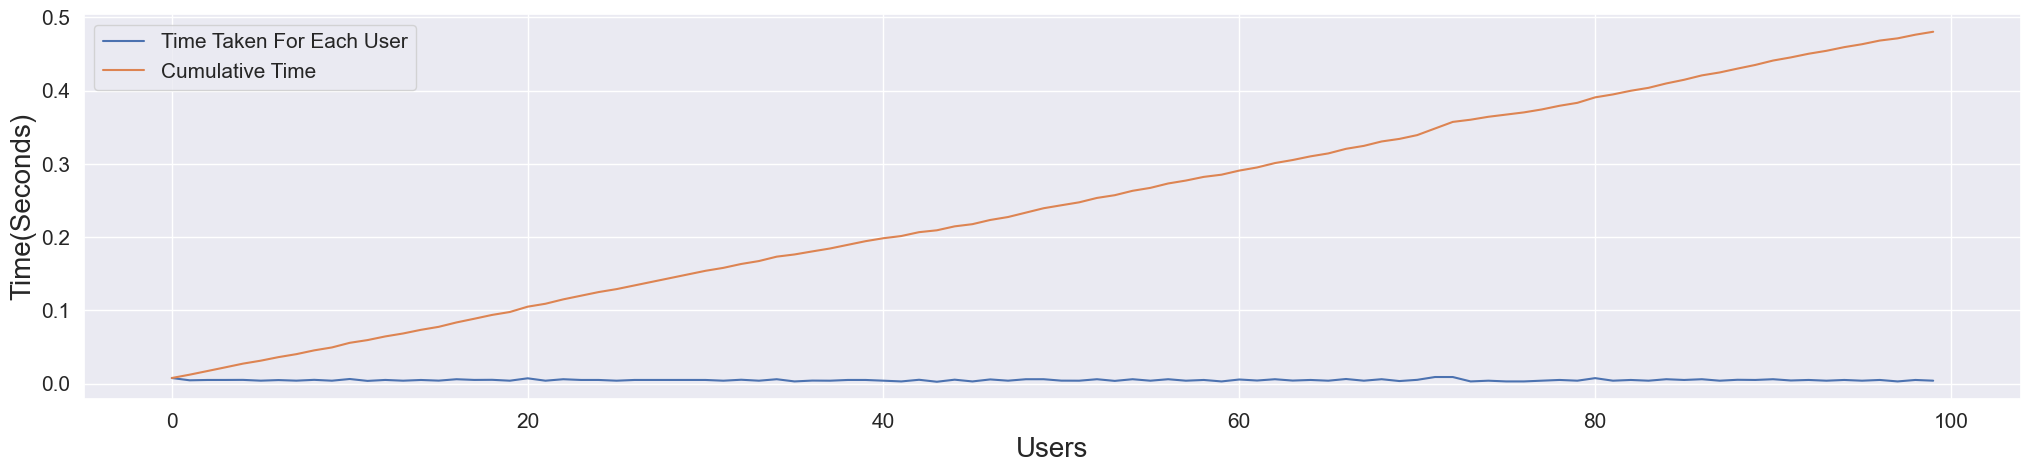

In [89]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

def getUser_UserSimilarity(sparseMatrix, top=100):
    startTimestamp20 = datetime.now()

    row_index, col_index = sparseMatrix.nonzero()
    rows = np.unique(row_index)
    similarMatrix = np.zeros((sparseMatrix.shape[0], top))  # Adjusted to match the number of rows in sparseMatrix
    timeTaken = []
    howManyDone = 0
    for row in rows[:top]:
        howManyDone += 1
        startTimestamp = datetime.now().timestamp()
        sim = cosine_similarity(sparseMatrix.getrow(row), sparseMatrix).ravel()
        top_similar_indices = sim.argsort()[-top:]
        top_similar = sim[top_similar_indices]
        similarMatrix[row, :len(top_similar)] = top_similar  # Assign only to valid indices
        timeforOne = datetime.now().timestamp() - startTimestamp
        timeTaken.append(timeforOne)
        if howManyDone % 20 == 0:
            print("Time elapsed for {} users = {}sec".format(howManyDone, (datetime.now() - startTimestamp20)))
    print("Average Time taken to compute similarity matrix for 1 user = " + str(sum(timeTaken) / len(timeTaken)) + "seconds")

    sns.set(style="darkgrid")
    fig = plt.figure(figsize=(25, 5))
    plt.plot(timeTaken, label='Time Taken For Each User')
    plt.plot(np.cumsum(timeTaken), label='Cumulative Time')
    plt.legend(loc='upper left', fontsize=15)
    plt.xlabel('Users', fontsize=20)
    plt.ylabel('Time(Seconds)', fontsize=20)
    plt.tick_params(labelsize=15)
    plt.show()

    return similarMatrix

# Assuming TrainUISparseData is defined elsewhere
simMatrix = getUser_UserSimilarity(TrainUISparseData, 100)


In [90]:
# Calculating user-user similarity only for particular users in our sparse matrix and return user_ids

def Calculate_User_User_Similarity(sparseMatrix, user_id, num_of_similar_users=10):
    
    if user_id in unique_user_id:
        # Calculating the cosine similarity for user_id with all the "userId"
        sim = cosine_similarity(sparseMatrix.getrow(user_id), sparseMatrix).ravel()
        # Sorting the indexs(user_id) based on the similarity score for all the user ids
        top_similar_user_ids = sim.argsort()[::-1]
        # Sorted the similarity values
        top_similarity_values = sim[top_similar_user_ids]

    return top_similar_user_ids[1: num_of_similar_users+1]

In [91]:
# Getting top 5 users similar to userId: 1

similar_users_1 = Calculate_User_User_Similarity(TrainUISparseData, 1, 5)
similar_users_1

array([266, 313, 368,  57, 469], dtype=int64)

---

#### **Feature Extraction**



In [92]:
# Path for saving/loading files

In [93]:
import numpy as np
import scipy.sparse as sparse

def get_sample_sparse_matrix(sparseMatrix, n_users, n_movies, matrix_name):
    """
    Function to get a sample sparse matrix
    :param sparseMatrix: Original sparse matrix
    :param n_users: Number of users for sampling
    :param n_movies: Number of movies for sampling
    :param matrix_name: Name of the sample matrix file
    :return: Sampled sparse matrix
    """
    users, movies, ratings = sparse.find(sparseMatrix)
    uniq_users = np.unique(users)
    uniq_movies = np.unique(movies)
    
    if n_users > len(uniq_users) or n_movies > len(uniq_movies):
        replace_users = n_users > len(uniq_users)
        replace_movies = n_movies > len(uniq_movies)
        print("Sample size larger than population. Setting replace to", replace_users, "for users and", replace_movies, "for movies")
    else:
        replace_users = False
        replace_movies = False
    
    userS = np.random.choice(uniq_users, n_users, replace=replace_users)
    movieS = np.random.choice(uniq_movies, n_movies, replace=replace_movies)
    mask = np.logical_and(np.isin(users, userS), np.isin(movies, movieS))
    sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (users[mask], movies[mask])), 
                                             shape=(max(userS)+1, max(movieS)+1))
    sparse.save_npz(matrix_name, sample_sparse_matrix)
    return sample_sparse_matrix

# Now, calling the function
if not os.path.isfile("TrainUISparseData_Sample.npz"):
    print("Sample sparse matrix is not present in the disk. We are creating it...")
    train_sample_sparse = get_sample_sparse_matrix(TrainUISparseData, 5000, 1000, "TrainUISparseData_Sample.npz")
else:
    print("File is already present in the disk. Loading the file...")
    train_sample_sparse = sparse.load_npz("TrainUISparseData_Sample.npz")
    print("Shape of Train Sample Sparse Matrix =", train_sample_sparse.shape)


File is already present in the disk. Loading the file...
Shape of Train Sample Sparse Matrix = (610, 9169)


In [94]:
# Creating Sample Sparse Matrix for Test Data

if not os.path.isfile(file_path + "/TestUISparseData_Sample.npz"):
    print("Sample sparse matrix is not present in the disk. We are creating it...")
    test_sample_sparse = get_sample_sparse_matrix(TestUISparseData, 2000, 200, "TestUISparseData_Sample.npz")
else:
    print("File is already present in the disk. Loading the file...")
    test_sample_sparse = sparse.load_npz(file_path + "/TestUISparseData_Sample.npz")
    print("Shape of Test Sample Sparse Matrix = " + str(test_sample_sparse.shape))

Sample sparse matrix is not present in the disk. We are creating it...
Sample size larger than population. Setting replace to True for users and False for movies


In [95]:
# Checking the shape of Training and test data

print("Shape of Train Sparse Matrix : ", train_sample_sparse.shape)
print("Shape of Test Sparse Matrix : ", test_sample_sparse.shape)

Shape of Train Sparse Matrix :  (610, 9169)
Shape of Test Sparse Matrix :  (611, 9739)


In [96]:
# Calculating few GlobalAverageRating, AvgMovieRating, AvgUserRating and TotalNoOfRatings

globalAvgRating = np.round((train_sample_sparse.sum()/train_sample_sparse.count_nonzero()), 2)
globalAvgMovies = getAverageRatings(train_sample_sparse, False)
globalAvgUsers = getAverageRatings(train_sample_sparse, True)
print("Global average of all movies ratings in Train matrix is : ", globalAvgRating)
print("No. of ratings in the train matrix is : ", train_sample_sparse.count_nonzero())

Global average of all movies ratings in Train matrix is :  3.54
No. of ratings in the train matrix is :  9631


In [97]:
# Function to extract features and create row using the sparse matrix

def CreateFeaturesForTrainData(SampledSparseData, TrainSampledSparseData):

    startTime = datetime.now()

    # Extracting userId list, movieId list and Ratings
    sample_users, sample_movies, sample_ratings = sparse.find(SampledSparseData)
    
    print("No. of rows in the returned dataset : ", len(sample_ratings))
    
    count = 0
    data = []
    
    for user, movie, rating in zip(sample_users, sample_movies, sample_ratings):

        row = list()

#----------------------------------Appending "user Id" average, "movie Id" average & global average rating-----------#
        row.append(user)  
        row.append(movie) 
        row.append(globalAvgRating) 

#----------------------------------Appending "user" average, "movie" average & rating of "user""movie"-----------#
        try:
            row.append(globalAvgUsers[user])
        except (KeyError):
            global_average_rating = globalAvgRating
            row.append(global_average_rating)
        except:
            raise
        try:            
            row.append(globalAvgMovies[movie])
        except (KeyError):
            global_average_rating = globalAvgRating
            row.append(global_average_rating)
        except:
            raise

#----------------------------------Ratings given to "movie" by top 5 similar users with "user"--------------------#
        try:
            similar_users = cosine_similarity(TrainSampledSparseData[user], TrainSampledSparseData).ravel()
            similar_users_indices = np.argsort(-similar_users)[1:]
            similar_users_ratings = TrainSampledSparseData[similar_users_indices, movie].toarray().ravel()
            top_similar_user_ratings = list(similar_users_ratings[similar_users_ratings != 0][:5])
            top_similar_user_ratings.extend([globalAvgMovies[movie]]*(5-len(top_similar_user_ratings)))
            #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "movie" average
            #rating. Let say only 3 out of 5 ratings are available then rest 2 will be "movie" average rating.
            row.extend(top_similar_user_ratings)
        #########Cold Start Problem, for a new user or a new movie######### 
        except (IndexError, KeyError):
            global_average_rating = [globalAvgRating]*5
            row.extend(global_average_rating)
        except:
            raise

#----------------------------------Ratings given by "user" to top 5 similar movies with "movie"------------------#
        try:
            similar_movies = cosine_similarity(TrainSampledSparseData[:,movie].T, TrainSampledSparseData.T).ravel()
            similar_movies_indices = np.argsort(-similar_movies)[1:]
            similar_movies_ratings = TrainSampledSparseData[user, similar_movies_indices].toarray().ravel()
            top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
            top_similar_movie_ratings.extend([globalAvgUsers[user]]*(5-len(top_similar_movie_ratings)))
            #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "user" average
            #rating. Let say only 3 out of 5 ratings are available then rest 2 will be "user" average rating.
            row.extend(top_similar_movie_ratings)
        ########Cold Start Problem, for a new user or a new movie#########
        except (IndexError, KeyError):
            global_average_rating = [globalAvgRating] * 5
            row.extend(global_average_rating)
        except:
            raise
              
#----------------------------------Appending rating of "user""movie"-----------#
        row.append(rating)

        count += 1
        
        data.append(row)
        
        if count % 5000 == 0:
            print("Done for {}. Time elapsed: {}".format(count, (datetime.now() - startTime)))

    print("Total Time for {} rows = {}".format(len(data), (datetime.now() - startTime)))
    print("Completed..")
    return data

In [98]:
# Using sampled train data, creating Features for each row and saving it into the list

data_rows = CreateFeaturesForTrainData(train_sample_sparse, train_sample_sparse)

No. of rows in the returned dataset :  9631
Done for 5000. Time elapsed: 0:00:23.512422
Total Time for 9631 rows = 0:00:45.239658
Completed..


In [99]:
# Using sampled train data, creating Features for each row and saving it into the list

test_data_rows = CreateFeaturesForTrainData(test_sample_sparse, train_sample_sparse)

No. of rows in the returned dataset :  748
Total Time for 748 rows = 0:00:03.012627
Completed..


In [100]:
# Creating the pandas dataframe from the data rows extracted from the sparse matrix and splitted into train and test data set

names = ["User_ID", "Movie_ID", "Global_Average", "User_Average", "Movie_Average", "SUR1", "SUR2", "SUR3", "SUR4", "SUR5", "SMR1", "SMR2",
         "SMR3", "SMR4", "SMR5", "Rating"]
train_regression_data = pd.DataFrame(data_rows, columns=names)
test_regression_data = pd.DataFrame(test_data_rows, columns=names)

In [101]:
#save into csv file
train_regression_data.to_csv("Training_Data_For_Regression.csv")
test_regression_data.to_csv("Testing_Data_For_Regression.csv")


In [102]:
# Loading the train and test csv files

# Path for saving/loading files
file_path = "/content/drive/MyDrive/Colab Datasets/Movie Recommendation"

print("File is already present in the disk. Loading the file...")

train_regression_data = pd.read_csv("Training_Data_For_Regression.csv")
train_regression_data = train_regression_data.drop(["Unnamed: 0"], axis=1)

test_regression_data = pd.read_csv("Testing_Data_For_Regression.csv")
test_regression_data = test_regression_data.drop(["Unnamed: 0"], axis=1)
      
print("Done..")


File is already present in the disk. Loading the file...
Done..


In [103]:
# Checking the shape and first few records for train data

print("The shape of the dataframe is : ", train_regression_data.shape)
print("Number of missing Values : ", train_regression_data.isnull().sum().sum())
train_regression_data.head()

The shape of the dataframe is :  (9631, 16)
Number of missing Values :  0


,User_ID,Movie_ID,Global_Average,User_Average,Movie_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,Rating
0,1,44,3.54,4.428571,3.971098,3.0,4.0,5.0,4.0,4.0,3.0,5.0,3.0,5.0,5.0,5
1,1,137,3.54,4.428571,3.540984,3.0,4.0,3.0,4.0,3.0,5.0,3.0,5.0,4.0,4.0,5
2,1,198,3.54,4.428571,3.040650,5.0,3.0,4.0,2.0,5.0,5.0,3.0,3.0,5.0,5.0,5
3,1,258,3.54,4.428571,4.132576,5.0,5.0,4.0,5.0,4.0,5.0,4.0,5.0,3.0,5.0,3
4,1,437,3.54,4.428571,3.453125,4.0,3.0,4.0,2.0,3.0,3.0,5.0,5.0,5.0,5.0,3


In [104]:
# Checking the shape and first few records for test data

print("The shape of the dataframe is : ", test_regression_data.shape)
print("Number of missing Values : ", test_regression_data.isnull().sum().sum())
test_regression_data.head()

The shape of the dataframe is :  (748, 16)
Number of missing Values :  0


,User_ID,Movie_ID,Global_Average,User_Average,Movie_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,Rating
0,15,899,3.54,5.0,3.54,3.54,3.54,3.54,3.54,3.54,5.0,5.0,5.0,5.0,5.0,5.0
1,15,916,3.54,5.0,3.54,3.54,3.54,3.54,3.54,3.54,5.0,5.0,5.0,5.0,5.0,5.0
2,15,2675,3.54,5.0,3.54,3.54,3.54,3.54,3.54,3.54,5.0,5.0,5.0,5.0,5.0,5.0
3,15,3195,3.54,5.0,3.54,3.54,3.54,3.54,3.54,3.54,5.0,5.0,5.0,5.0,5.0,3.0
4,15,3462,3.54,5.0,3.54,3.54,3.54,3.54,3.54,3.54,5.0,5.0,5.0,5.0,5.0,5.0


In [105]:
#Observations:

#The description of the features are stated below:
#1. User_ID: ID of a this User
#2. Movie_ID: ID of a this Movie
#3. Global_Average: Global Average Rating
#4. User_Average: Average Rating of this User
#5. Movie_Average: Average Rating of this Movie
#6. Ratings given to this Movie by top 5 similar users with this User: (SUR1, SUR2, SUR3, SUR4, SUR5)
#11. Ratings given by this User to top 5 similar movies with this Movie: (SMR1, SMR2, SMR3, SMR4, SMR5)
#16. Rating: Rating given by this User to this Movie



**Transforming Data for Surprise Models**



In [106]:
train_regression_data[['User_ID', 'Movie_ID', 'Rating']].head(5)

,User_ID,Movie_ID,Rating
0,1,44,5
1,1,137,5
2,1,198,5
3,1,258,3
4,1,437,3


In [107]:
# Using Surprise library Data Structures to build the train data set

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(train_regression_data[["User_ID", "Movie_ID", "Rating"]], reader)
trainset = data.build_full_trainset()

In [108]:
# Creating tuple for test set

testset = list(zip(test_regression_data["User_ID"].values, test_regression_data["Movie_ID"].values, test_regression_data["Rating"].values))

In [109]:
# Utilities to save the modelling results

error_cols = ["Model", "Train RMSE", "Train MAPE", "Test RMSE", "Test MAPE"]
error_table = pd.DataFrame(columns=["Model", "RMSE_train", "MAPE_train", "RMSE_test", "MAPE_test"])
#error_table = pd.DataFrame(columns = error_cols)
model_train_evaluation = dict()
model_test_evaluation = dict()

In [110]:
######################### Function to save modelling results in a table

#def make_table(model_name, rmse_train, mape_train, rmse_test, mape_test):
#    global error_table
#    error_table = error_table.append(pd.DataFrame([[model_name, rmse_train, mape_train, rmse_test, mape_test]], columns = error_cols))
#    error_table.reset_index(drop = True, inplace = True)
    

def make_table(model_name, rmse_train, mape_train, rmse_test, mape_test):
    global error_table
    # Append data to error_table
    error_table = error_table._append(pd.DataFrame([[model_name, rmse_train, mape_train, rmse_test, mape_test]], columns=["Model", "RMSE_train", "MAPE_train", "RMSE_test", "MAPE_test"]), ignore_index=True)


In [111]:
############################ Function to calulate RMSE and MAPE values

def error_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(abs((y_true - y_pred)/y_true))*100
    return rmse, mape


In [112]:
# Apply Xgboost Regressor on the Train and Test Data

def train_test_xgboost(x_train, x_test, y_train, y_test, model_name):
    
    startTime = datetime.now()
    train_result = dict()
    test_result = dict()
    
    clf = xgb.XGBRegressor(n_estimators = 100, silent = False, n_jobs  = 10)
    clf.fit(x_train, y_train)
    
    print("-" * 50)
    print("TRAIN DATA")
    y_pred_train = clf.predict(x_train)
    rmse_train, mape_train = error_metrics(y_train, y_pred_train)
    print("RMSE : {}".format(rmse_train))
    print("MAPE : {}".format(mape_train))
    train_result = {"RMSE": rmse_train, "MAPE": mape_train, "Prediction": y_pred_train}
    
    print("-" * 50)
    print("TEST DATA")
    y_pred_test = clf.predict(x_test)
    rmse_test, mape_test = error_metrics(y_test, y_pred_test)
    print("RMSE : {}".format(rmse_test))
    print("MAPE : {}".format(mape_test))
    test_result = {"RMSE": rmse_test, "MAPE": mape_test, "Prediction": y_pred_test}
        
    print("-"*50)
    print("Time Taken : ", datetime.now() - startTime)
    
    plot_importance(xgb, clf)
    make_table(model_name, rmse_train, mape_train, rmse_test, mape_test)
    
    return train_result, test_result

# Function to plot feature importance for a model

def plot_importance(model, clf):
    
    sns.set(style="darkgrid")
    fig = plt.figure(figsize = (25, 5))
    ax = fig.add_axes([0, 0, 1, 1])
    
    model.plot_importance(clf, ax = ax, height = 0.3)
    plt.xlabel("F Score", fontsize = 20)
    plt.ylabel("Features", fontsize = 20)
    plt.title("Feature Importance", fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.show()

In [113]:
# in surprise prediction of every data point is returned as dictionary like this:
# "user: 196        item: 302        r_ui = 4.00   est = 4.06   {'actual_k': 40, 'was_impossible': False}"
# In this dictionary, "r_ui" is a key for actual rating and "est" is a key for predicted rating

def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    predicted = np.array([pred.est for pred in predictions])
    return actual, predicted

def get_error(predictions):
    actual, predicted = get_ratings(predictions)
    rmse = np.sqrt(mean_squared_error(actual, predicted)) 
    mape = np.mean(abs((actual - predicted)/actual))*100
    return rmse, mape

In [114]:
my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

########## Running Surprise model algorithms
def run_surprise(algo, trainset, testset, model_name):

    startTime = datetime.now()
    
    train = dict()
    test = dict()
    
    algo.fit(trainset)
    
#-----------------Evaluating Train Data------------------#
    print("-"*50)
    print("TRAIN DATA")
    train_pred = algo.test(trainset.build_testset())
    train_actual, train_predicted = get_ratings(train_pred)
    train_rmse, train_mape = get_error(train_pred)
    print("RMSE = {}".format(train_rmse))
    print("MAPE = {}".format(train_mape))
    train = {"RMSE": train_rmse, "MAPE": train_mape, "Prediction": train_predicted}
    
#-----------------Evaluating Test Data------------------#
    print("-"*50)
    print("TEST DATA")
    test_pred = algo.test(testset)
    test_actual, test_predicted = get_ratings(test_pred)
    test_rmse, test_mape = get_error(test_pred)
    print("RMSE = {}".format(test_rmse))
    print("MAPE = {}".format(test_mape))
    test = {"RMSE": test_rmse, "MAPE": test_mape, "Prediction": test_predicted}

    print("-"*50)    
    print("Time Taken = "+str(datetime.now() - startTime))
    
    make_table(model_name, train_rmse, train_mape, test_rmse, test_mape)
    
    return train, test

###  Train/test Splitting



In [115]:
# Creating the train-test X and y variables for the ML algos

x_train = train_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
x_test = test_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
y_train = train_regression_data["Rating"]
y_test = test_regression_data["Rating"]

### **4.2 Model Fitting**

Fitting various models and checking its accuracy.


--------------------------------------------------
TRAIN DATA
RMSE : 0.5022152039678236
MAPE : 12.95033060455976
--------------------------------------------------
TEST DATA
RMSE : 1.2786652199290154
MAPE : 53.869343117131166
--------------------------------------------------
Time Taken :  0:00:00.289813


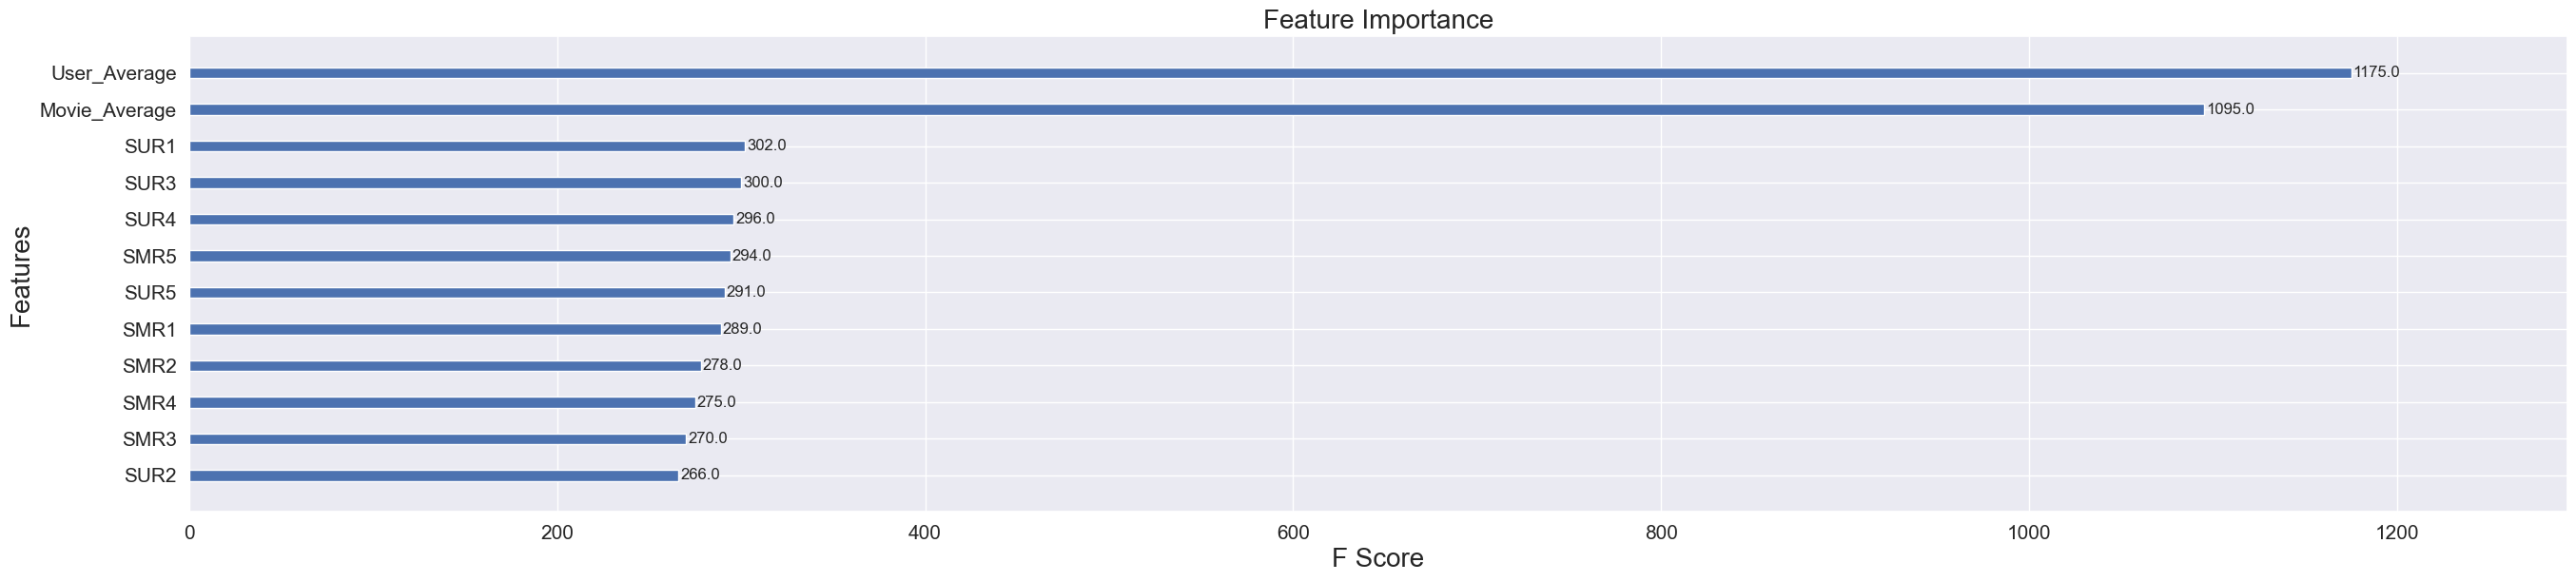

In [116]:
# Training the Xgboost Regression Model on with the 13 features

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGBoost_13")

model_train_evaluation["XGBoost_13"] = train_result
model_test_evaluation["XGBoost_13"] = test_result

Observations:

1. "User_Average" by far seems to be the most important feature for rating prediction.
2. "Movie_Average" is the second most important feature to predict the ratings.
3. The top 5 Similar User ratings and top 5 Similar Movie Ratings doesn't seems to be the effective features.

In [117]:
# Applying BaselineOnly from the surprise library to predict the ratings

bsl_options = {"method":"sgd", "learning_rate":0.01, "n_epochs":25}

algo = BaselineOnly(bsl_options=bsl_options)

train_result, test_result = run_surprise(algo, trainset, testset, "BaselineOnly")

model_train_evaluation["BaselineOnly"] = train_result
model_test_evaluation["BaselineOnly"] = test_result

Estimating biases using sgd...
--------------------------------------------------
TRAIN DATA
RMSE = 0.7747624195012214
MAPE = 22.912241473383542
--------------------------------------------------
TEST DATA
RMSE = 1.1158324874673347
MAPE = 44.690110113153956
--------------------------------------------------
Time Taken = 0:00:00.274640


In [118]:
# Adding predicted ratings from Surprise BaselineOnly model to our Train and Test Dataframe

train_regression_data["BaselineOnly"] = model_train_evaluation["BaselineOnly"]["Prediction"]
test_regression_data["BaselineOnly"] = model_test_evaluation["BaselineOnly"]["Prediction"]

In [119]:
train_regression_data.head()

,User_ID,Movie_ID,Global_Average,User_Average,Movie_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,Rating,BaselineOnly
0,1,44,3.54,4.428571,3.971098,3.0,4.0,5.0,4.0,4.0,3.0,5.0,3.0,5.0,5.0,5,4.847769
1,1,137,3.54,4.428571,3.540984,3.0,4.0,3.0,4.0,3.0,5.0,3.0,5.0,4.0,4.0,5,4.407151
2,1,198,3.54,4.428571,3.040650,5.0,3.0,4.0,2.0,5.0,5.0,3.0,3.0,5.0,5.0,5,3.858866
3,1,258,3.54,4.428571,4.132576,5.0,5.0,4.0,5.0,4.0,5.0,4.0,5.0,3.0,5.0,3,5.000000
4,1,437,3.54,4.428571,3.453125,4.0,3.0,4.0,2.0,3.0,3.0,5.0,5.0,5.0,5.0,3,4.372600


In [120]:
test_regression_data.head()

,User_ID,Movie_ID,Global_Average,User_Average,Movie_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,Rating,BaselineOnly
0,15,899,3.54,5.0,3.54,3.54,3.54,3.54,3.54,3.54,5.0,5.0,5.0,5.0,5.0,5.0,3.87212
1,15,916,3.54,5.0,3.54,3.54,3.54,3.54,3.54,3.54,5.0,5.0,5.0,5.0,5.0,5.0,3.87212
2,15,2675,3.54,5.0,3.54,3.54,3.54,3.54,3.54,3.54,5.0,5.0,5.0,5.0,5.0,5.0,3.87212
3,15,3195,3.54,5.0,3.54,3.54,3.54,3.54,3.54,3.54,5.0,5.0,5.0,5.0,5.0,3.0,3.87212
4,15,3462,3.54,5.0,3.54,3.54,3.54,3.54,3.54,3.54,5.0,5.0,5.0,5.0,5.0,5.0,3.87212


--------------------------------------------------
TRAIN DATA
RMSE : 0.4840350639505335
MAPE : 12.405208175569268
--------------------------------------------------
TEST DATA
RMSE : 1.3091969333559401
MAPE : 55.54648983947552
--------------------------------------------------
Time Taken :  0:00:00.296818


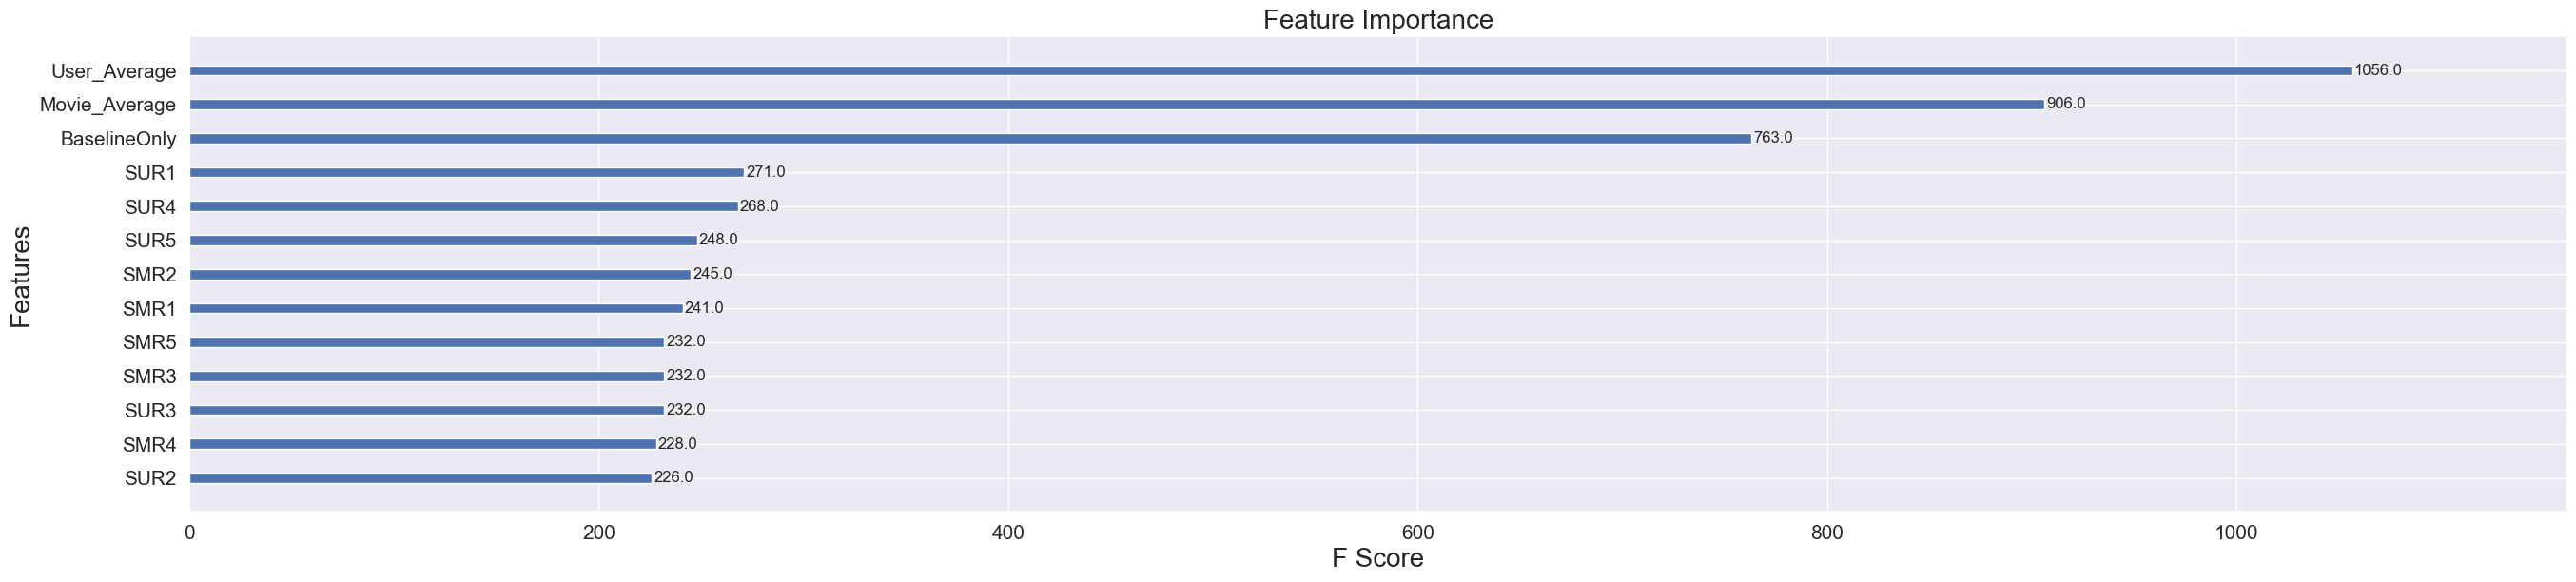

In [121]:
# Fitting the Xgboost again with new BaselineOnly feature

x_train = train_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
x_test = test_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
y_train = train_regression_data["Rating"]
y_test = test_regression_data["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL")

model_train_evaluation["XGB_BSL"] = train_result
model_test_evaluation["XGB_BSL"] = test_result

Observations:

1. The "BaselineOnly" feature is also not an important feature.

In [122]:
# Finding the suitable parameter for Surprise KNN-Baseline with User-User Similarity

param_grid  = {'sim_options':{'name': ["pearson_baseline"], "user_based": [True],
                              "min_support": [2], "shrinkage": [60, 80, 80, 140]}, 'k': [5, 20, 40, 80]}
gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])
# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

In [123]:
# Applying the KNN-Baseline with the searched parameters

sim_options = {'name':'pearson_baseline', 'user_based':True, 'min_support':2, 'shrinkage':gs.best_params['rmse']['sim_options']['shrinkage']}

bsl_options = {'method': 'sgd'} 

algo = KNNBaseline(k = gs.best_params['rmse']['k'], sim_options = sim_options, bsl_options=bsl_options)

train_result, test_result = run_surprise(algo, trainset, testset, "KNNBaseline_User")

model_train_evaluation["KNNBaseline_User"] = train_result
model_test_evaluation["KNNBaseline_User"] = test_result

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
--------------------------------------------------
TRAIN DATA
RMSE = 0.19462138368115808
MAPE = 4.4532873208891175
--------------------------------------------------
TEST DATA
RMSE = 1.1179749846703027
MAPE = 44.73999941452375
--------------------------------------------------
Time Taken = 0:00:00.978216


In [124]:
# Similarly finding best parameters for Surprise KNN-Baseline with Item-Item Similarity

param_grid  = {'sim_options':{'name': ["pearson_baseline"], "user_based": [False],
                              "min_support": [2], "shrinkage": [60, 80, 80, 140]}, 'k': [5, 20, 40, 80]}

gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

In [125]:
# Applying KNN-Baseline with best parameters searched

sim_options = {'name':'pearson_baseline', 'user_based':False, 'min_support':2, 'shrinkage':gs.best_params['rmse']['sim_options']['shrinkage']}

bsl_options = {'method': 'sgd'} 

algo = KNNBaseline(k = gs.best_params['rmse']['k'], sim_options = sim_options, bsl_options=bsl_options)

train_result, test_result = run_surprise(algo, trainset, testset, "KNNBaseline_Item")

model_train_evaluation["KNNBaseline_Item"] = train_result
model_test_evaluation["KNNBaseline_Item"] = test_result

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
--------------------------------------------------
TRAIN DATA
RMSE = 0.1967079626384702
MAPE = 4.72263825118061
--------------------------------------------------
TEST DATA
RMSE = 1.1161163200676982
MAPE = 44.690140782684836
--------------------------------------------------
Time Taken = 0:00:01.183158


In [126]:
# Addding the KNNBaseline features to the train and test dataset

train_regression_data["KNNBaseline_User"] = model_train_evaluation["KNNBaseline_User"]["Prediction"]
train_regression_data["KNNBaseline_Item"] = model_train_evaluation["KNNBaseline_Item"]["Prediction"]

test_regression_data["KNNBaseline_User"] = model_test_evaluation["KNNBaseline_User"]["Prediction"]
test_regression_data["KNNBaseline_Item"] = model_test_evaluation["KNNBaseline_Item"]["Prediction"]

In [127]:
train_regression_data.head()

,User_ID,Movie_ID,Global_Average,User_Average,Movie_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,Rating,BaselineOnly,KNNBaseline_User,KNNBaseline_Item
0,1,44,3.54,4.428571,3.971098,3.0,4.0,5.0,4.0,4.0,3.0,5.0,3.0,5.0,5.0,5,4.847769,4.857272,4.743224
1,1,137,3.54,4.428571,3.540984,3.0,4.0,3.0,4.0,3.0,5.0,3.0,5.0,4.0,4.0,5,4.407151,4.853848,4.728330
2,1,198,3.54,4.428571,3.040650,5.0,3.0,4.0,2.0,5.0,5.0,3.0,3.0,5.0,5.0,5,3.858866,4.636773,4.552577
3,1,258,3.54,4.428571,4.132576,5.0,5.0,4.0,5.0,4.0,5.0,4.0,5.0,3.0,5.0,3,5.000000,3.969999,4.227718
4,1,437,3.54,4.428571,3.453125,4.0,3.0,4.0,2.0,3.0,3.0,5.0,5.0,5.0,5.0,3,4.372600,3.661673,3.398643


In [128]:
test_regression_data.head()

,User_ID,Movie_ID,Global_Average,User_Average,Movie_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,Rating,BaselineOnly,KNNBaseline_User,KNNBaseline_Item
0,15,899,3.54,5.0,3.54,3.54,3.54,3.54,3.54,3.54,5.0,5.0,5.0,5.0,5.0,5.0,3.87212,3.684369,3.684369
1,15,916,3.54,5.0,3.54,3.54,3.54,3.54,3.54,3.54,5.0,5.0,5.0,5.0,5.0,5.0,3.87212,3.684369,3.684369
2,15,2675,3.54,5.0,3.54,3.54,3.54,3.54,3.54,3.54,5.0,5.0,5.0,5.0,5.0,5.0,3.87212,3.684369,3.684369
3,15,3195,3.54,5.0,3.54,3.54,3.54,3.54,3.54,3.54,5.0,5.0,5.0,5.0,5.0,3.0,3.87212,3.684369,3.684369
4,15,3462,3.54,5.0,3.54,3.54,3.54,3.54,3.54,3.54,5.0,5.0,5.0,5.0,5.0,5.0,3.87212,3.684369,3.684369


--------------------------------------------------
TRAIN DATA
RMSE : 0.002349158713228463
MAPE : 0.03460592439322936
--------------------------------------------------
TEST DATA
RMSE : 1.1908625646077535
MAPE : 49.082992916023805
--------------------------------------------------
Time Taken :  0:00:00.312405


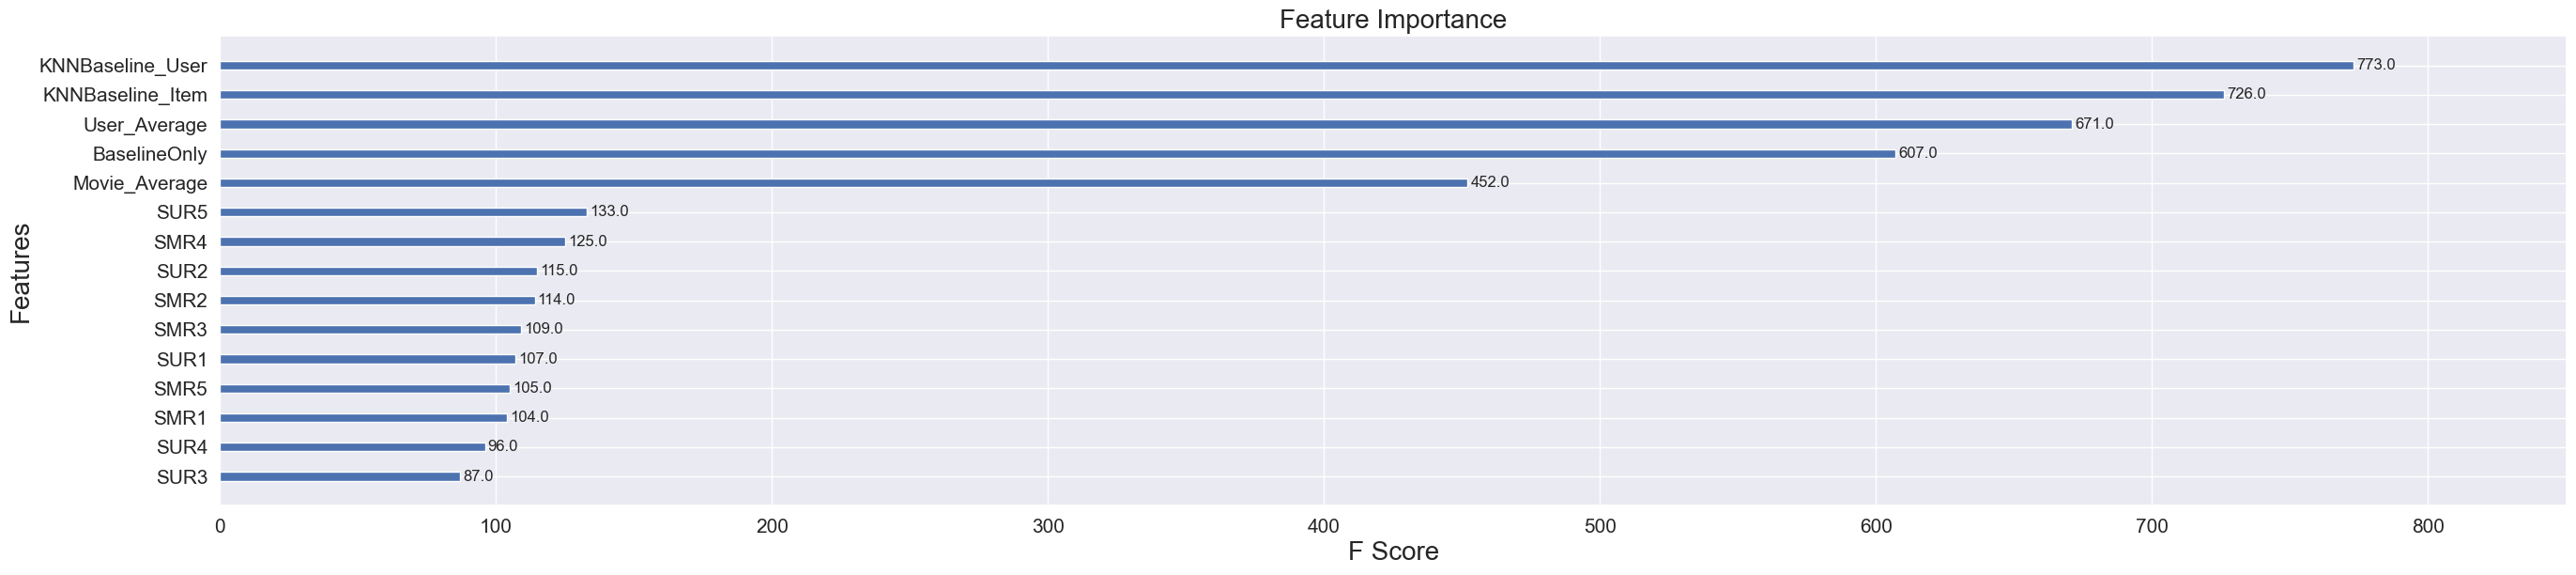

In [129]:
# Applying Xgboost with the KNN-Baseline newly added features

x_train = train_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
x_test = test_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

y_train = train_regression_data["Rating"]
y_test = test_regression_data["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL_KNN")

model_train_evaluation["XGB_BSL_KNN"] = train_result
model_test_evaluation["XGB_BSL_KNN"] = test_result

Observations:

1. The KNN Baseline features are also not an effective predictor.

In [130]:
# Appling the SlopeOne algorithm from the Surprise library

so = SlopeOne()

train_result, test_result = run_surprise(so, trainset, testset, "SlopeOne")

model_train_evaluation["SlopeOne"] = train_result
model_test_evaluation["SlopeOne"] = test_result

--------------------------------------------------
TRAIN DATA
RMSE = 0.5861019761008184
MAPE = 15.68407837857041
--------------------------------------------------
TEST DATA
RMSE = 1.1346603866979923
MAPE = 45.58140238170182
--------------------------------------------------
Time Taken = 0:00:00.616412


In [131]:
# Adding the SlopOne predictions to the train and test datasets

train_regression_data["SlopeOne"] = model_train_evaluation["SlopeOne"]["Prediction"]
train_regression_data["SlopeOne"] = model_train_evaluation["SlopeOne"]["Prediction"]

test_regression_data["SlopeOne"] = model_test_evaluation["SlopeOne"]["Prediction"]
test_regression_data["SlopeOne"] = model_test_evaluation["SlopeOne"]["Prediction"]

In [132]:
# Matrix Factorization using SVD from Surprise Library

# here, n_factors is the equivalent to dimension 'd' when matrix 'A'
# is broken into 'b' and 'c'. So, matrix 'A' will be of dimension n*m. So, matrices 'b' and 'c' will be of dimension n*d and m*d.
param_grid  = {'n_factors': [5,7,10,15,20,25,35,50,70,90]}   

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8741735634280122
{'n_factors': 5}


In [133]:
# Applying SVD with best parameters

algo = SVD(n_factors = gs.best_params['rmse']['n_factors'], biased=True, verbose=True)

train_result, test_result = run_surprise(algo, trainset, testset, "SVD")

model_train_evaluation["SVD"] = train_result
model_test_evaluation["SVD"] = test_result

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
--------------------------------------------------
TRAIN DATA
RMSE = 0.7930977513199974
MAPE = 23.873153341266057
--------------------------------------------------
TEST DATA
RMSE = 1.1159133823299987
MAPE = 44.68407142098881
--------------------------------------------------
Time Taken = 0:00:00.168650


In [134]:
# Matrix Factorization SVDpp with implicit feedback

# Hyper-parameter optimization for SVDpp
param_grid = {'n_factors': [10, 30, 50, 80, 100], 'lr_all': [0.002, 0.006, 0.018, 0.054, 0.10]}

gs = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8706321368751749
{'n_factors': 10, 'lr_all': 0.006}


In [135]:
#Applying SVDpp with best parameters¶

algo = SVDpp(n_factors = gs.best_params['rmse']['n_factors'], lr_all = gs.best_params['rmse']["lr_all"], verbose=True)

train_result, test_result = run_surprise(algo, trainset, testset, "SVDpp")

model_train_evaluation["SVDpp"] = train_result
model_test_evaluation["SVDpp"] = test_result

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
--------------------------------------------------
TRAIN DATA
RMSE = 0.7443743531360222
MAPE = 22.104476748405304
--------------------------------------------------
TEST DATA
RMSE = 1.1160380225940763
MAPE = 44.69737973793573
--------------------------------------------------
Time Taken = 0:00:02.425208


In [136]:
# XGBoost 13 Features + Surprise BaselineOnly + Surprise KNN Baseline + SVD + SVDpp

train_regression_data["SVD"] = model_train_evaluation["SVD"]["Prediction"]
train_regression_data["SVDpp"] = model_train_evaluation["SVDpp"]["Prediction"]

test_regression_data["SVD"] = model_test_evaluation["SVD"]["Prediction"]
test_regression_data["SVDpp"] = model_test_evaluation["SVDpp"]["Prediction"]

In [137]:
train_regression_data.head()

,User_ID,Movie_ID,Global_Average,User_Average,Movie_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,Rating,BaselineOnly,KNNBaseline_User,KNNBaseline_Item,SlopeOne,SVD,SVDpp
0,1,44,3.54,4.428571,3.971098,3.0,4.0,5.0,4.0,4.0,3.0,5.0,3.0,5.0,5.0,5,4.847769,4.857272,4.743224,4.907950,4.772982,4.710510
1,1,137,3.54,4.428571,3.540984,3.0,4.0,3.0,4.0,3.0,5.0,3.0,5.0,4.0,4.0,5,4.407151,4.853848,4.728330,4.704141,4.364557,4.357248
2,1,198,3.54,4.428571,3.040650,5.0,3.0,4.0,2.0,5.0,5.0,3.0,3.0,5.0,5.0,5,3.858866,4.636773,4.552577,4.107378,3.824582,3.924456
3,1,258,3.54,4.428571,4.132576,5.0,5.0,4.0,5.0,4.0,5.0,4.0,5.0,3.0,5.0,3,5.000000,3.969999,4.227718,5.000000,4.911973,4.871916
4,1,437,3.54,4.428571,3.453125,4.0,3.0,4.0,2.0,3.0,3.0,5.0,5.0,5.0,5.0,3,4.372600,3.661673,3.398643,4.083901,4.304053,4.324165


In [138]:
test_regression_data.head()

,User_ID,Movie_ID,Global_Average,User_Average,Movie_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,Rating,BaselineOnly,KNNBaseline_User,KNNBaseline_Item,SlopeOne,SVD,SVDpp
0,15,899,3.54,5.0,3.54,3.54,3.54,3.54,3.54,3.54,5.0,5.0,5.0,5.0,5.0,5.0,3.87212,3.684369,3.684369,3.544388,3.685034,3.706477
1,15,916,3.54,5.0,3.54,3.54,3.54,3.54,3.54,3.54,5.0,5.0,5.0,5.0,5.0,5.0,3.87212,3.684369,3.684369,3.544388,3.685034,3.706477
2,15,2675,3.54,5.0,3.54,3.54,3.54,3.54,3.54,3.54,5.0,5.0,5.0,5.0,5.0,5.0,3.87212,3.684369,3.684369,3.544388,3.685034,3.706477
3,15,3195,3.54,5.0,3.54,3.54,3.54,3.54,3.54,3.54,5.0,5.0,5.0,5.0,5.0,3.0,3.87212,3.684369,3.684369,3.544388,3.685034,3.706477
4,15,3462,3.54,5.0,3.54,3.54,3.54,3.54,3.54,3.54,5.0,5.0,5.0,5.0,5.0,5.0,3.87212,3.684369,3.684369,3.544388,3.685034,3.706477


--------------------------------------------------
TRAIN DATA
RMSE : 0.0021422426519318847
MAPE : 0.029242878138773527
--------------------------------------------------
TEST DATA
RMSE : 1.203182116532571
MAPE : 49.56653235865494
--------------------------------------------------
Time Taken :  0:00:00.272707


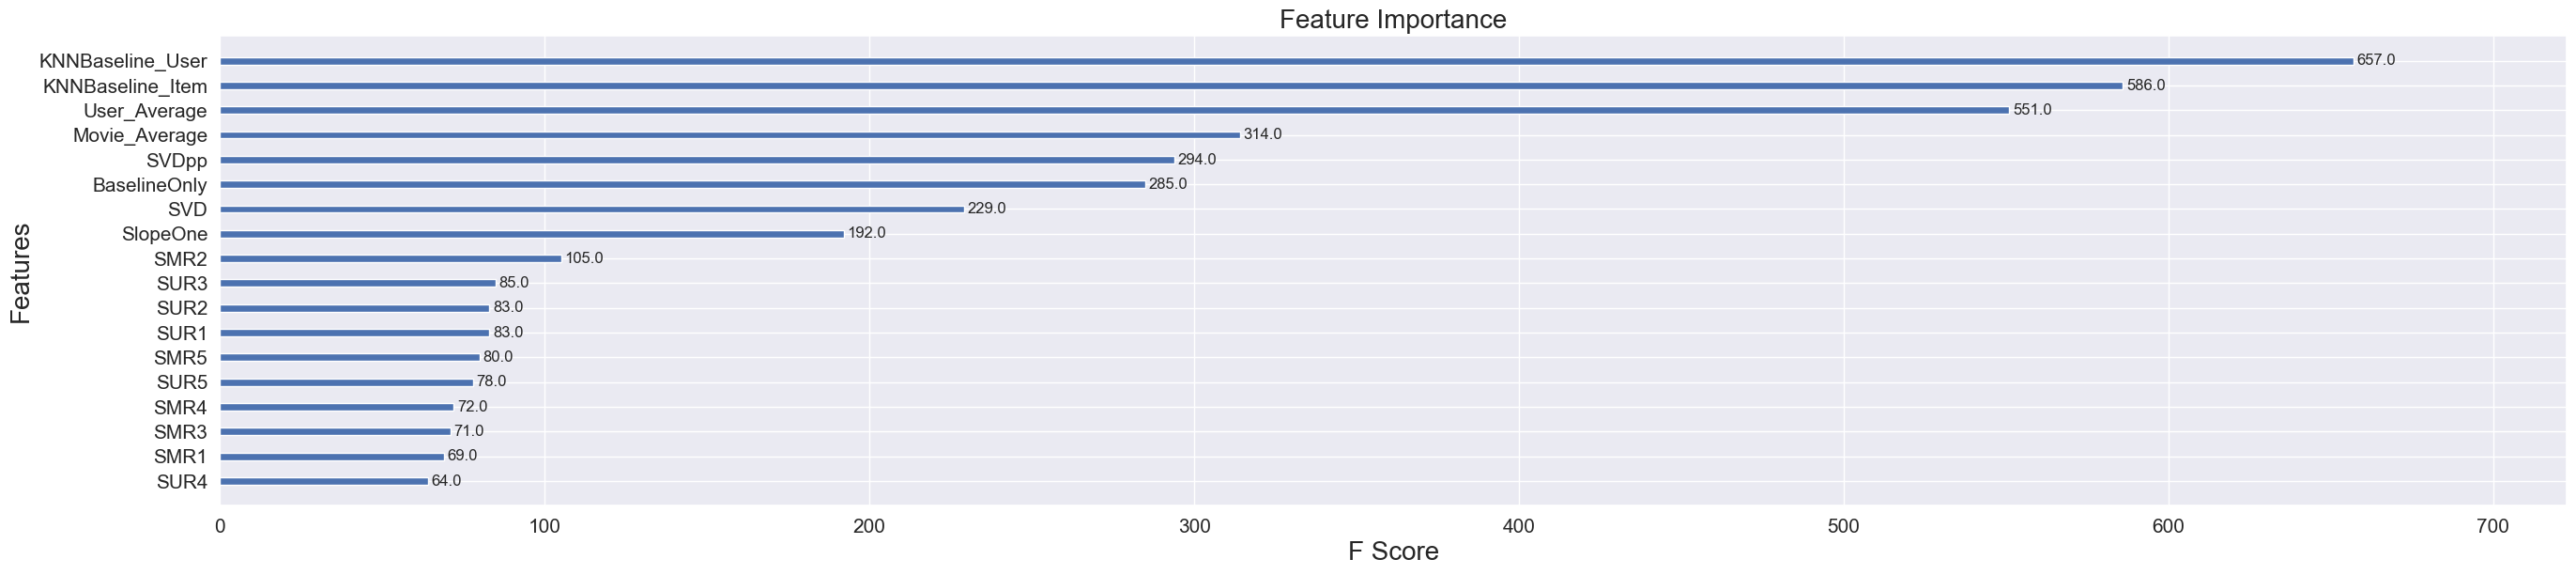

In [139]:
# Applying Xgboost on the feature set

x_train = train_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
x_test = test_regression_data.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

y_train = train_regression_data["Rating"]
y_test = test_regression_data["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL_KNN_MF")

model_train_evaluation["XGB_BSL_KNN_MF"] = train_result
model_test_evaluation["XGB_BSL_KNN_MF"] = test_result

Observations:

1. SVD did better than KNNBaseline features but SVDpp turned out to be the most ineffective predictor.

--------------------------------------------------
TRAIN DATA
RMSE : 0.00263962714748968
MAPE : 0.030873855507906462
--------------------------------------------------
TEST DATA
RMSE : 1.1500122538952984
MAPE : 47.39978471556966
--------------------------------------------------
Time Taken :  0:00:00.233296


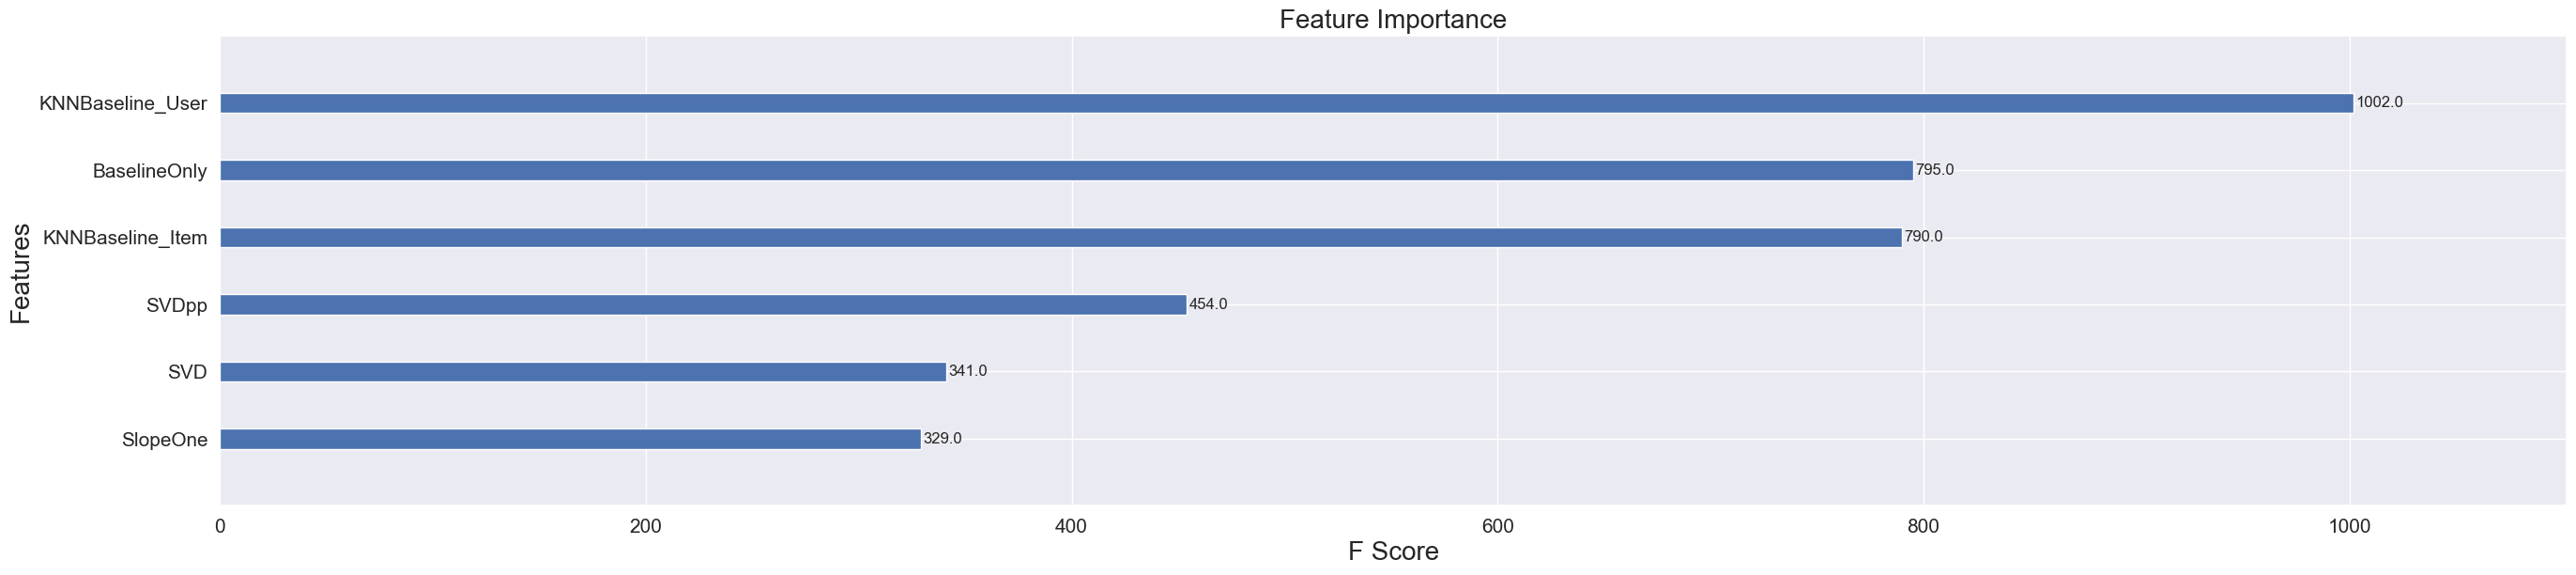

In [140]:
# Applying Xgboost with Surprise's BaselineOnly + KNN Baseline + SVD + SVDpp + SlopeOne

x_train = train_regression_data[["BaselineOnly", "KNNBaseline_User", "KNNBaseline_Item", "SVD", "SVDpp", "SlopeOne"]]
x_test = test_regression_data[["BaselineOnly", "KNNBaseline_User", "KNNBaseline_Item", "SVD", "SVDpp", "SlopeOne"]]

y_train = train_regression_data["Rating"]
y_test = test_regression_data["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_KNN_MF_SO")

model_train_evaluation["XGB_KNN_MF_SO"] = train_result
model_test_evaluation["XGB_KNN_MF_SO"] = test_result

Observations:

1. SVD seems to be the best estimator of the rating predictions.
2. SVDpp and Baseline Only also seems to be a important feature.
3. SlopeOne, KNNBaseline features are also decent estimators.

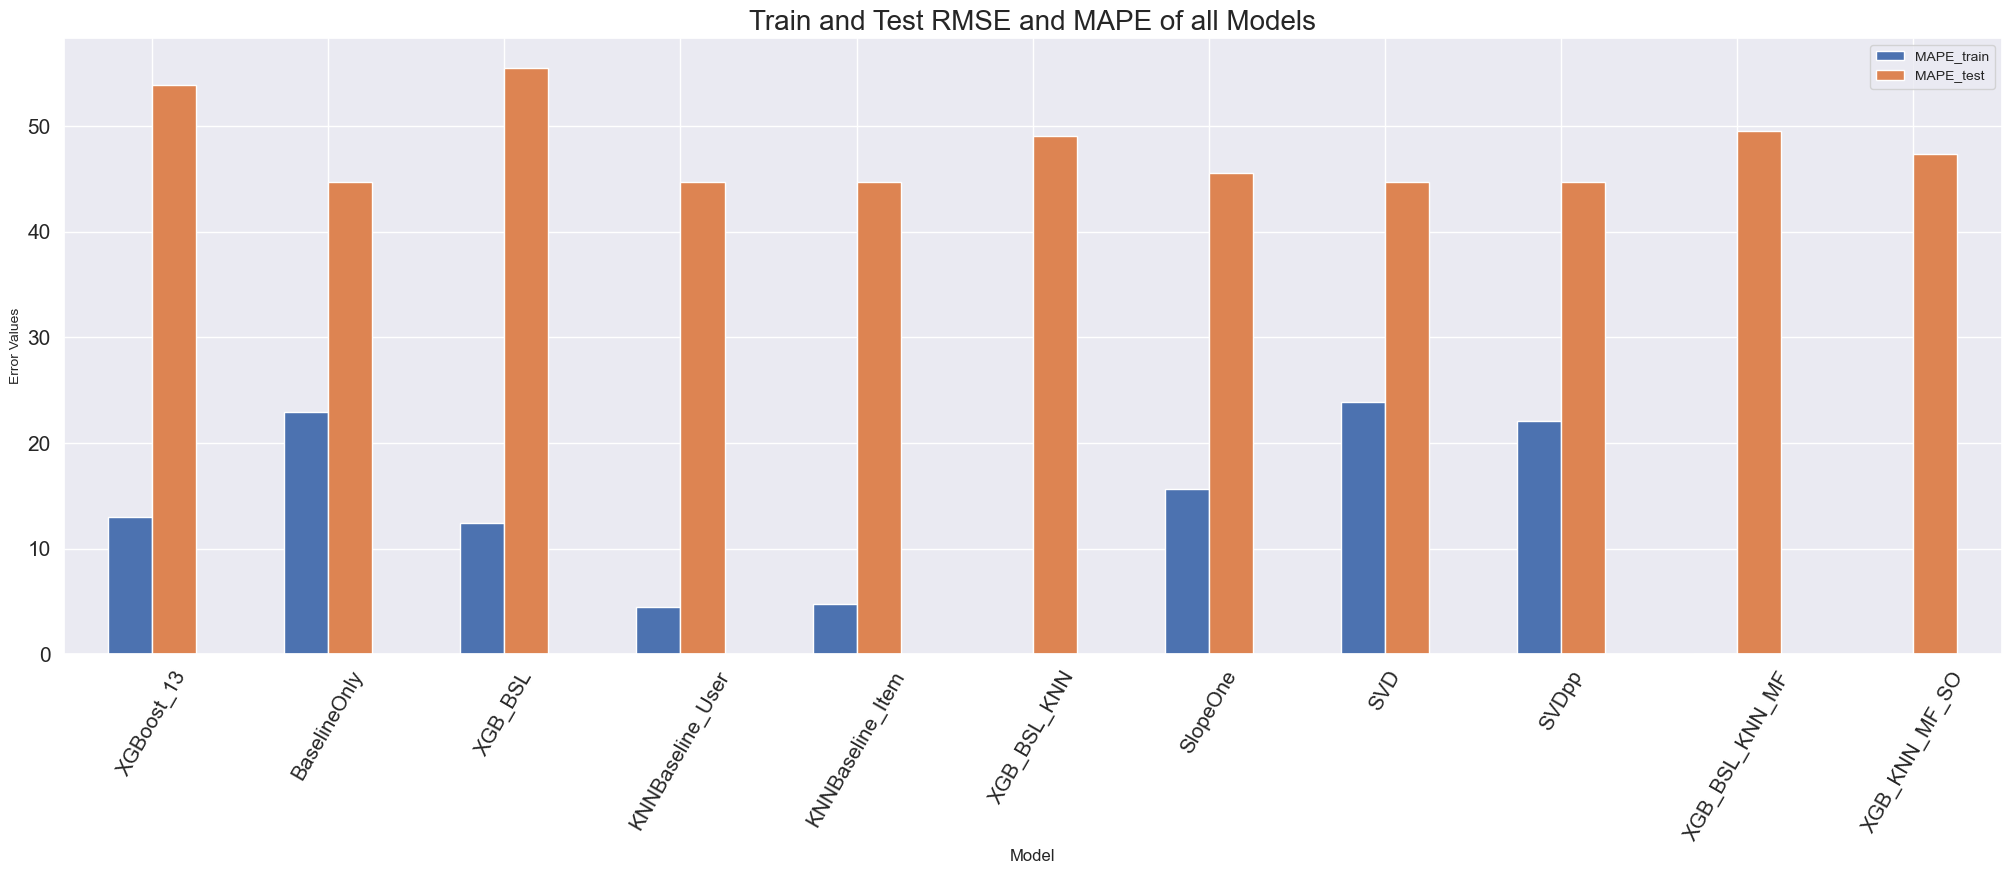

In [141]:
# Visualizing the errors of all the models we tested out

# Drop columns only if they exist in the DataFrame
error_table2 = error_table.drop(["RMSE_train", "RMSE_test"], axis=1, errors='ignore')
#error_table2 = error_table.drop(["Train MAPE", "Test MAPE"], axis = 1)
error_table2.plot(x = "Model", kind = "bar", figsize = (25, 8), grid = True, fontsize = 15)


plt.title("Train and Test RMSE and MAPE of all Models", fontsize = 20)
plt.ylabel("Error Values", fontsize = 10)
plt.xticks(rotation=60)
plt.legend(bbox_to_anchor=(1, 1), fontsize = 10)
plt.show()

In [142]:
# Tabular Values of Errors

error_table.drop(["Train MAPE", "Test MAPE"], axis = 1, errors='ignore')

,Model,RMSE_train,MAPE_train,RMSE_test,MAPE_test
0,XGBoost_13,0.502215,12.950331,1.278665,53.869343
1,BaselineOnly,0.774762,22.912241,1.115832,44.690110
2,XGB_BSL,0.484035,12.405208,1.309197,55.546490
3,KNNBaseline_User,0.194621,4.453287,1.117975,44.739999
4,KNNBaseline_Item,0.196708,4.722638,1.116116,44.690141
5,XGB_BSL_KNN,0.002349,0.034606,1.190863,49.082993
6,SlopeOne,0.586102,15.684078,1.134660,45.581402
7,SVD,0.793098,23.873153,1.115913,44.684071
8,SVDpp,0.744374,22.104477,1.116038,44.697380
9,XGB_BSL_KNN_MF,0.002142,0.029243,1.203182,49.566532


Observations:
1. All the algorithms seems to do great with the differences remaining very close to each other.

2. We can see that by using various rating predicting algorithms together and stacking them up, then using final algorithms seems to result in lowest Testing RMSE. Eg: Surprise's BaselineOnly + KNN Baseline + SVD + SVDpp + SlopeOne together with Xgboost.

3. SlopeOne seems to have lowest Testing RMSE out of all other algorithms.

4. SVDpp and SVD are algorithms showing lower Testing RMSE among rest of the predictors except SlopeOne.


### **4.3 Generating Recommendation for Users**

We are using SVDpp to generate atmost 10 recommendated movies for various users.

In [143]:
# Testing the recommendations made by SVDpp Algorithm

from collections import defaultdict

def Get_top_n(predictions, n=10):

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, mid, true_r, est, _ in predictions:
        top_n[uid].append((mid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [144]:
# Creating instance of svd_pp

svd_pp = SVDpp(n_factors = 10, lr_all = 0.006, verbose=True)
svd_pp.fit(trainset)
predictions = svd_pp.test(testset)

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19


In [145]:
# Saving the training predictions

train_pred = svd_pp.test(trainset.build_anti_testset())
top_n = Get_top_n(train_pred, n=10)

In [146]:
# Print the recommended items for each user

def Generate_Recommendated_Movies(u_id, n=10):

    recommend = pd.DataFrame(top_n[u_id], columns=["Movie_Id", "Predicted_Rating"])
    recommend = recommend.merge(movies, how="inner", left_on="Movie_Id", right_on="movieId")
    recommend = recommend[["Movie_Id", "title", "genres", "Predicted_Rating"]]

    return recommend[:n]

In [147]:
# Saving the sampled user id list to help generate movies

sampled_user_id = list(top_n.keys())

In [148]:

# Generating recommendation using the user_Id

test_id = random.choice(sampled_user_id)
print("The user Id is : ", test_id)
Generate_Recommendated_Movies(test_id)

The user Id is :  249


,Movie_Id,title,genres,Predicted_Rating
0,864,Monty Python and the Holy Grail,Adventure|Comedy|Fantasy,4.491254
1,842,"Streetcar Named Desire, A",Drama,4.458887
2,681,"Philadelphia Story, The",Comedy|Drama|Romance,4.388448
3,692,"Apartment, The",Comedy|Drama|Romance,4.309082
4,136,Crumb,Documentary,4.301415
5,3985,Spirited Away (Sen to Chihiro no kamikakushi),Adventure|Animation|Fantasy,4.299393
6,945,Miller's Crossing,Crime|Drama|Film-Noir|Thriller,4.280300
7,2623,"Odd Couple, The",Comedy,4.274476
8,1703,"Player, The",Comedy|Crime|Drama,4.247690
9,758,Big Night,Comedy|Drama,4.247010


In [149]:
# Generating recommendation using the user_Id

test_id = random.choice(sampled_user_id)
print("The user Id is : ", test_id)
Generate_Recommendated_Movies(test_id)

The user Id is :  12


,Movie_Id,title,genres,Predicted_Rating
0,842,"Streetcar Named Desire, A",Drama,4.637082
1,681,"Philadelphia Story, The",Comedy|Drama|Romance,4.613507
2,3985,Spirited Away (Sen to Chihiro no kamikakushi),Adventure|Animation|Fantasy,4.546347
3,864,Monty Python and the Holy Grail,Adventure|Comedy|Fantasy,4.529686
4,906,12 Angry Men,Drama,4.513801
5,945,Miller's Crossing,Crime|Drama|Film-Noir|Thriller,4.483669
6,1703,"Player, The",Comedy|Crime|Drama,4.476858
7,2623,"Odd Couple, The",Comedy,4.462151
8,911,Once Upon a Time in the West (C'era una volta ...,Action|Drama|Western,4.459868
9,7011,Inglourious Basterds,Action|Drama|War,4.451937


In [150]:
# Generating recommendation using the user_Id

test_id = random.choice(sampled_user_id)
print("The user Id is : ", test_id)
Generate_Recommendated_Movies(test_id)

The user Id is :  42


,Movie_Id,title,genres,Predicted_Rating
0,906,12 Angry Men,Drama,4.450872
1,1703,"Player, The",Comedy|Crime|Drama,4.400240
2,681,"Philadelphia Story, The",Comedy|Drama|Romance,4.399149
3,842,"Streetcar Named Desire, A",Drama,4.397649
4,3985,Spirited Away (Sen to Chihiro no kamikakushi),Adventure|Animation|Fantasy,4.395520
5,864,Monty Python and the Holy Grail,Adventure|Comedy|Fantasy,4.384426
6,2623,"Odd Couple, The",Comedy,4.381134
7,1033,Cape Fear,Crime|Drama|Thriller,4.339458
8,692,"Apartment, The",Comedy|Drama|Romance,4.292279
9,8476,Guardians of the Galaxy,Action|Adventure|Sci-Fi,4.284628


In [151]:
# Generating recommendation using the user_Id

test_id = random.choice(sampled_user_id)
print("The user Id is : ", test_id)
Generate_Recommendated_Movies(test_id)

The user Id is :  188


,Movie_Id,title,genres,Predicted_Rating
0,842,"Streetcar Named Desire, A",Drama,4.881233
1,3985,Spirited Away (Sen to Chihiro no kamikakushi),Adventure|Animation|Fantasy,4.708445
2,864,Monty Python and the Holy Grail,Adventure|Comedy|Fantasy,4.691359
3,7011,Inglourious Basterds,Action|Drama|War,4.658025
4,911,Once Upon a Time in the West (C'era una volta ...,Action|Drama|Western,4.596603
5,1504,Saving Private Ryan,Action|Drama|War,4.581269
6,1703,"Player, The",Comedy|Crime|Drama,4.573298
7,692,"Apartment, The",Comedy|Drama|Romance,4.564516
8,945,Miller's Crossing,Crime|Drama|Film-Noir|Thriller,4.559219
9,2623,"Odd Couple, The",Comedy,4.558281


In [157]:
# Generating recommendation using the user_Id

test_id = random.choice(sampled_user_id)
print("The user Id is : ", test_id)
Generate_Recommendated_Movies(test_id)

The user Id is :  18


,Movie_Id,title,genres,Predicted_Rating
0,842,"Streetcar Named Desire, A",Drama,4.463847
1,681,"Philadelphia Story, The",Comedy|Drama|Romance,4.414394
2,3985,Spirited Away (Sen to Chihiro no kamikakushi),Adventure|Animation|Fantasy,4.231952
3,945,Miller's Crossing,Crime|Drama|Film-Noir|Thriller,4.228687
4,1703,"Player, The",Comedy|Crime|Drama,4.208079
5,2623,"Odd Couple, The",Comedy,4.195498
6,692,"Apartment, The",Comedy|Drama|Romance,4.183936
7,2016,"Red Violin, The (Violon rouge, Le)",Drama|Mystery,4.171618
8,1033,Cape Fear,Crime|Drama|Thriller,4.147872
9,938,"Seventh Seal, The (Sjunde inseglet, Det)",Drama,4.140464


In [ ]:
import csv
import pickle

# Define a list to store movies data
movies_data = []

# Read the movies data from a CSV file
with open('movies.csv', 'r', encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # Skip the header row
    for row in reader:
        movieId, title, genre = row
        movieId = int(movieId)
        movies_data.append({'movieId': movieId, 'title': title, 'genre': genre})

# Save movies_data to a pickle file
with open('movies_data.pkl', 'wb') as f:
    pickle.dump(movies_data, f)


In [ ]:
import csv
import pickle

# Define a dictionary to store ratings data
ratings_data = {}

# Read the ratings data from a CSV file
with open('ratings.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # Skip the header row
    for row in reader:
        userId, movieId, rating, timestamp = row
        userId = int(userId)
        movieId = int(movieId)
        rating = float(rating)
        if userId not in ratings_data:
            ratings_data[userId] = {}
        ratings_data[userId][movieId] = rating

# Save ratings_data to a pickle file
with open('ratings_data.pkl', 'wb') as f:
    pickle.dump(ratings_data, f)


In [ ]:
import pickle

# Save the SVD++ model
with open('svdpp_model.pkl', 'wb') as f:
    pickle.dump(svd_pp, f)

# Save the Get_top_n function
with open('get_top_n_function.pkl', 'wb') as f:
    pickle.dump(Get_top_n, f)

# Save the Generate_Recommendated_Movies function
with open('generate_recommendations_function.pkl', 'wb') as f:
    pickle.dump(Generate_Recommendated_Movies, f)

# Save the sampled user ID list
with open('sampled_user_id.pkl', 'wb') as f:
    pickle.dump(sampled_user_id, f)